In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
pd.set_option("display.max_rows", 100)

In [2]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append("..")

In [4]:
from bbox.connectors import SfMComponents, BBoxComponents
from bbox.bbox_transformations import bbox_to_global, img_to_global_coord
from bbox.io_utils import ParseXML

In [5]:
base_path = "/home/chinmays/Documents/PSI_Research/data/exports/semi-field/reference"
connector = SfMComponents(base_path)
gcp_reference = connector.gcp_reference
camera_reference = connector.camera_reference
image_path = "/home/chinmays/Documents/PSI_Research/data/exports/semi-field/developed_images/"

In [6]:
PITCH_THRESH = 30.
YAW_THRESH = 720.

In [7]:
annotation_file_path = "/home/chinmays/Documents/PSI_Research/data/exports/semi-field/annotations"

In [8]:
reader = ParseXML(image_path=image_path, label_path=annotation_file_path)

In [9]:
box_connector = BBoxComponents(reader, image_path, annotation_file_path)

In [10]:
imgs = box_connector.images
imgs = [
    img for img in imgs 
    if float(camera_reference[
        (camera_reference["label"] == img.id)
    ]["Estimated_Pitch"].abs()) < PITCH_THRESH
    and
    float(camera_reference[
        (camera_reference["label"] == img.id)
    ]["Estimated_Yaw"].abs()) < YAW_THRESH
]
len(imgs)

36

In [11]:
label_files = os.listdir(annotation_file_path)

In [15]:
print(marker_label)
gcp_reference[gcp_reference["label"] == marker_label]["Reference_X"]

target 9


Series([], Name: Reference_X, dtype: float64)

In [16]:
# target_store = dict()
# targets = dict()
# marker_labels = dict()
# targets_image = dict()

# for xml_file in label_files:
#     image_id = xml_file.split(".")[0]
    
#     file = os.path.join(annotation_file_path, xml_file)
    
#     _marker_labels = []
#     _targets = []
#     _targets_image = []

#     tree = ET.parse(file)
#     root = tree.getroot()

#     for item in root.findall("size"):
#         image_width = int(item.findall("width")[0].text)
#         image_height = int(item.findall("height")[0].text)

#     for items in root.findall("object"):
#         for item in items.findall("name"):
#             marker_label = f"target {item.text}"
#             target_x = float(gcp_reference[gcp_reference["label"] == marker_label]["Reference_X"])
#             target_y = float(gcp_reference[gcp_reference["label"] == marker_label]["Reference_Y"])
#             target = np.array([target_x, target_y])
            
#             stored_targets = target_store.get(marker_label, None)
#             if stored_targets is None: target_store[marker_label] = target
            
#             _targets.append(target)
#             _marker_labels.append(marker_label)

#         for item in items.findall("bndbox"):
#             xmin = int(item.findall("xmin")[0].text)
#             xmax = int(item.findall("xmax")[0].text)
#             ymin = int(item.findall("ymin")[0].text)
#             ymax = int(item.findall("ymax")[0].text)

#             top_right = [xmax, ymin]
#             bottom_left = [xmin, ymax]
#             top_left = [xmin, ymin]
#             bottom_right = [xmax, ymax]

#             target_x_image = xmin + (xmax - xmin)/2
#             target_y_image = ymin + (ymax - ymin)/2
#             target_coordinates_image = np.array([target_x_image, target_y_image])

#             _targets_image.append(target_coordinates_image)
            
#     targets[image_id] = {lb: coord for lb, coord in zip(_marker_labels, _targets)}
#     marker_labels[image_id] = _marker_labels
#     targets_image[image_id] = _targets_image

In [17]:
pixel_height = 0.00751588506046304
pixel_width = 0.00751588506046304

In [19]:
results = dict()
camera_centers = dict()
for image in imgs:
    
    camera_label = image.id
    
    yaw_angle = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_Yaw"])
    pitch_angle = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_Pitch"])
    roll_angle = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_Roll"])
    
    focal_length = float(camera_reference[camera_reference["label"] == camera_label]["f"])
    camera_height = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_Z"])
    camera_x = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_X"])
    camera_y = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_Y"])
    camera_center = [camera_x, camera_y]
    
    camera_centers[camera_label] = camera_center
    
    global_coordinates = dict()
    for bbox in image.bboxes.bboxes:
        # gt = targets[camera_label][bbox.cls]
        
        top_left = bbox.local_coordinates.top_left
        bottom_left = bbox.local_coordinates.bottom_left
        top_right = bbox.local_coordinates.top_right
        bottom_right = bbox.local_coordinates.bottom_right
        
        # Transformation
        global_top_left, global_top_right, global_bottom_left, global_bottom_right = bbox_to_global(
            top_left, top_right, bottom_left, bottom_right, 
            camera_center, pixel_width, pixel_height, focal_length, 
            image_width, image_height, camera_height, 
            yaw_angle, pitch_angle, roll_angle
        )
        
        global_coordinates[bbox.cls] = {
            "top_left": global_top_left,
            "top_right": global_top_right,
            "bottom_left": global_bottom_left,
            "bottom_right": global_bottom_right
        }
    results[camera_label] = global_coordinates
    

In [23]:
inverse_results = dict()
for camera_id, glb_coords in results.items():
    for target_id, coords in glb_coords.items():
        try:
            inverse_results[target_id][camera_id] = coords
        except Exception:
            inverse_results[target_id] = {camera_id: coords}

In [24]:
inverse_results

{'target 6': {'row4_2': {'top_left': array([0.54304051, 0.71232724]),
   'top_right': array([0.86506261, 0.75879506]),
   'bottom_left': array([0.58250903, 0.42742021]),
   'bottom_right': array([0.90509212, 0.47353817])},
  'row5_6': {'top_left': array([0.77254443, 0.72228025]),
   'top_right': array([0.85304573, 0.73727919]),
   'bottom_left': array([0.81155782, 0.50672251]),
   'bottom_right': array([0.89222356, 0.52162534])},
  'row3_5': {'top_left': array([0.54238967, 0.74134484]),
   'top_right': array([0.88426175, 0.7742872 ]),
   'bottom_left': array([0.56334855, 0.5251294 ]),
   'bottom_right': array([0.90558574, 0.5578021 ])},
  'row4_6': {'top_left': array([0.56423913, 0.72187739]),
   'top_right': array([0.85608256, 0.76558041]),
   'bottom_left': array([0.58374827, 0.58904512]),
   'bottom_right': array([0.87590439, 0.63255275])},
  'row4_3': {'top_left': array([0.55409883, 0.71734592]),
   'top_right': array([0.87385038, 0.76426386]),
   'bottom_left': array([0.59525268, 

In [25]:

def print_coords(global_coords):
    print("Top Left", global_coords["top_left"])
    print("Top Right", global_coords["top_right"])
    print("Bottom Left", global_coords["bottom_left"])
    print("Bottom Right", global_coords["bottom_right"])

def plot_vertices(coords, ax):
    ax.scatter(coords["top_left"][0], coords["top_left"][1], c="r") # Top Left
    ax.scatter(coords["top_right"][0], coords["top_right"][1], c="g") # Top Right
    ax.scatter(coords["bottom_left"][0], coords["bottom_left"][1], c="b") # Bottom Left
    ax.scatter(coords["bottom_right"][0], coords["bottom_right"][1], c="y") # Bottom Right
    
def plot_rectangle(centers, global_coords, colors=None, targets=[]):
    
    import random
    random.seed(424242)
    
    pairs = set()
    if len(global_coords) == 1:
        lb1 = list(global_coords.keys())[0]
        pitch1 = float(camera_reference[camera_reference["label"] == lb1]["Estimated_Pitch"])
        roll1 = float(camera_reference[camera_reference["label"] == lb1]["Estimated_Roll"])
    for lb1, box1 in global_coords.items():
        for lb2, box2 in global_coords.items():
            if lb1 == lb2:
                continue
            key = ",".join(sorted((lb1,lb2)))
            pitch1 = float(camera_reference[camera_reference["label"] == lb1]["Estimated_Pitch"])
            pitch2 = float(camera_reference[camera_reference["label"] == lb2]["Estimated_Pitch"])
            roll1 = float(camera_reference[camera_reference["label"] == lb1]["Estimated_Roll"])
            roll2 = float(camera_reference[camera_reference["label"] == lb2]["Estimated_Roll"])
            
            if key in pairs:
                continue
            printstr = ""
            iou = bb_iou(box1, box2)
            printstr += f"IOU - {lb1}, {lb2}: {iou}"
            print(printstr)
            pairs.add(key)
    
    f, ax = plt.subplots(1, 1, dpi=300)
    ax.set_aspect("equal", adjustable="box")
    
    cameras = global_coords.keys()
    handles = []
    labels = []
    for camera in cameras: # center in centers:
        r, g, b = random.random(), random.random(), random.random()
        color = (r, g, b)
        
        _center = centers[camera]
        
        handle = ax.scatter(_center[0], _center[1], marker="x", color=color)
        
        global_coord = global_coords[camera]
        anchor = tuple(global_coord["bottom_left"])
        width = global_coord["top_right"][0] - global_coord["top_left"][0]
        height = global_coord["top_left"][1] - global_coord["bottom_left"][1]
        patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=color, linewidth=1)
        ax.add_patch(patch)
        handles.append(handle)
        pitch1 = float(camera_reference[camera_reference["label"] == camera]["Estimated_Pitch"])
        roll1 = float(camera_reference[camera_reference["label"] == camera]["Estimated_Roll"])
        yaw1 = float(camera_reference[camera_reference["label"] == camera]["Estimated_Yaw"])
        label = camera + " Yaw: {:.4f}, Pitch: {:.4f}, Roll: {:.4f}".format(yaw1, pitch1, roll1)
        labels.append(label)
    
    target_colors = ["r", "c", "y"]

    if targets:
        for t, target in enumerate(targets):
            handle = ax.scatter(target[0], target[1], marker="*", c=target_colors[t])

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend(handles, labels, ncol=2, loc="lower left", fontsize="xx-small", bbox_to_anchor=(0.8, 1.0))
    
    plt.show()
    
def bb_iou(_boxA, _boxB):
    
    boxA = [_boxA["top_left"][0], -_boxA["top_left"][1], _boxA["bottom_right"][0], -_boxA["bottom_right"][1]]
    boxB = [_boxB["top_left"][0], -_boxB["top_left"][1], _boxB["bottom_right"][0], -_boxB["bottom_right"][1]]
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

IOU - row2_6, row2_5: 0.8859006451589021


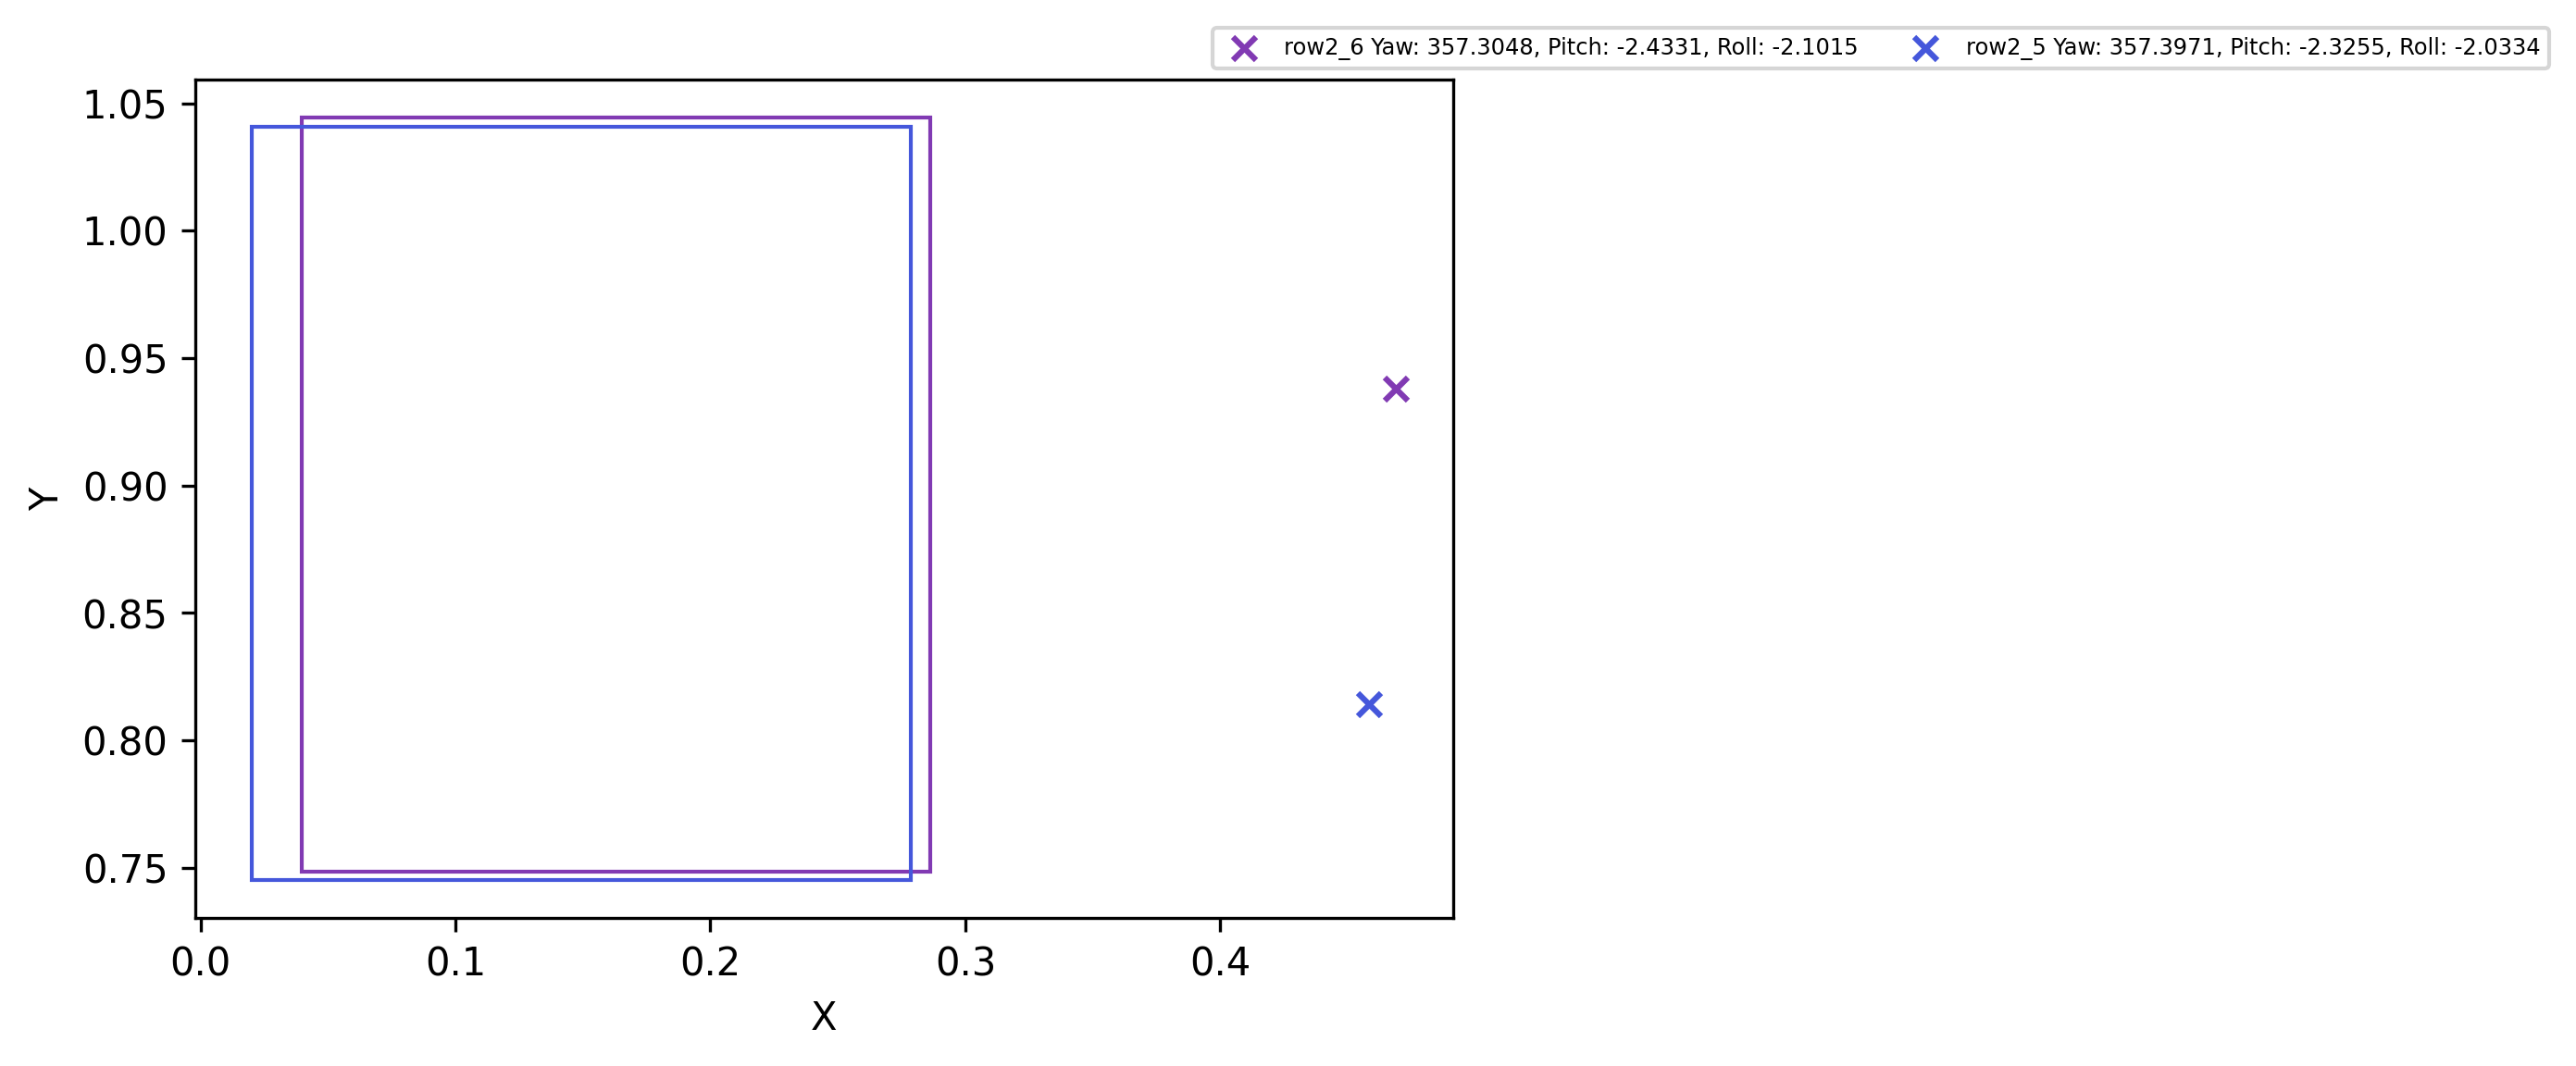

In [26]:
target_to_plot = "target 1"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=None)

IOU - row3_5, row3_3: 0.5344734767968796
IOU - row3_5, row3_4: 0.9219270559798282
IOU - row3_5, row2_6: 0.7233397859385915
IOU - row3_5, row2_5: 0.7922918136230949
IOU - row3_5, row3_6: 0.9290450960776095
IOU - row3_3, row3_4: 0.5470829922556254
IOU - row3_3, row2_6: 0.47617770481568933
IOU - row3_3, row2_5: 0.5216605538128434
IOU - row3_3, row3_6: 0.5368743855946307
IOU - row3_4, row2_6: 0.7289697896582348
IOU - row3_4, row2_5: 0.7985550654502096
IOU - row3_4, row3_6: 0.8579752322665538
IOU - row2_6, row2_5: 0.9096694816909932
IOU - row2_6, row3_6: 0.717659306898043
IOU - row2_5, row3_6: 0.7859067054337563


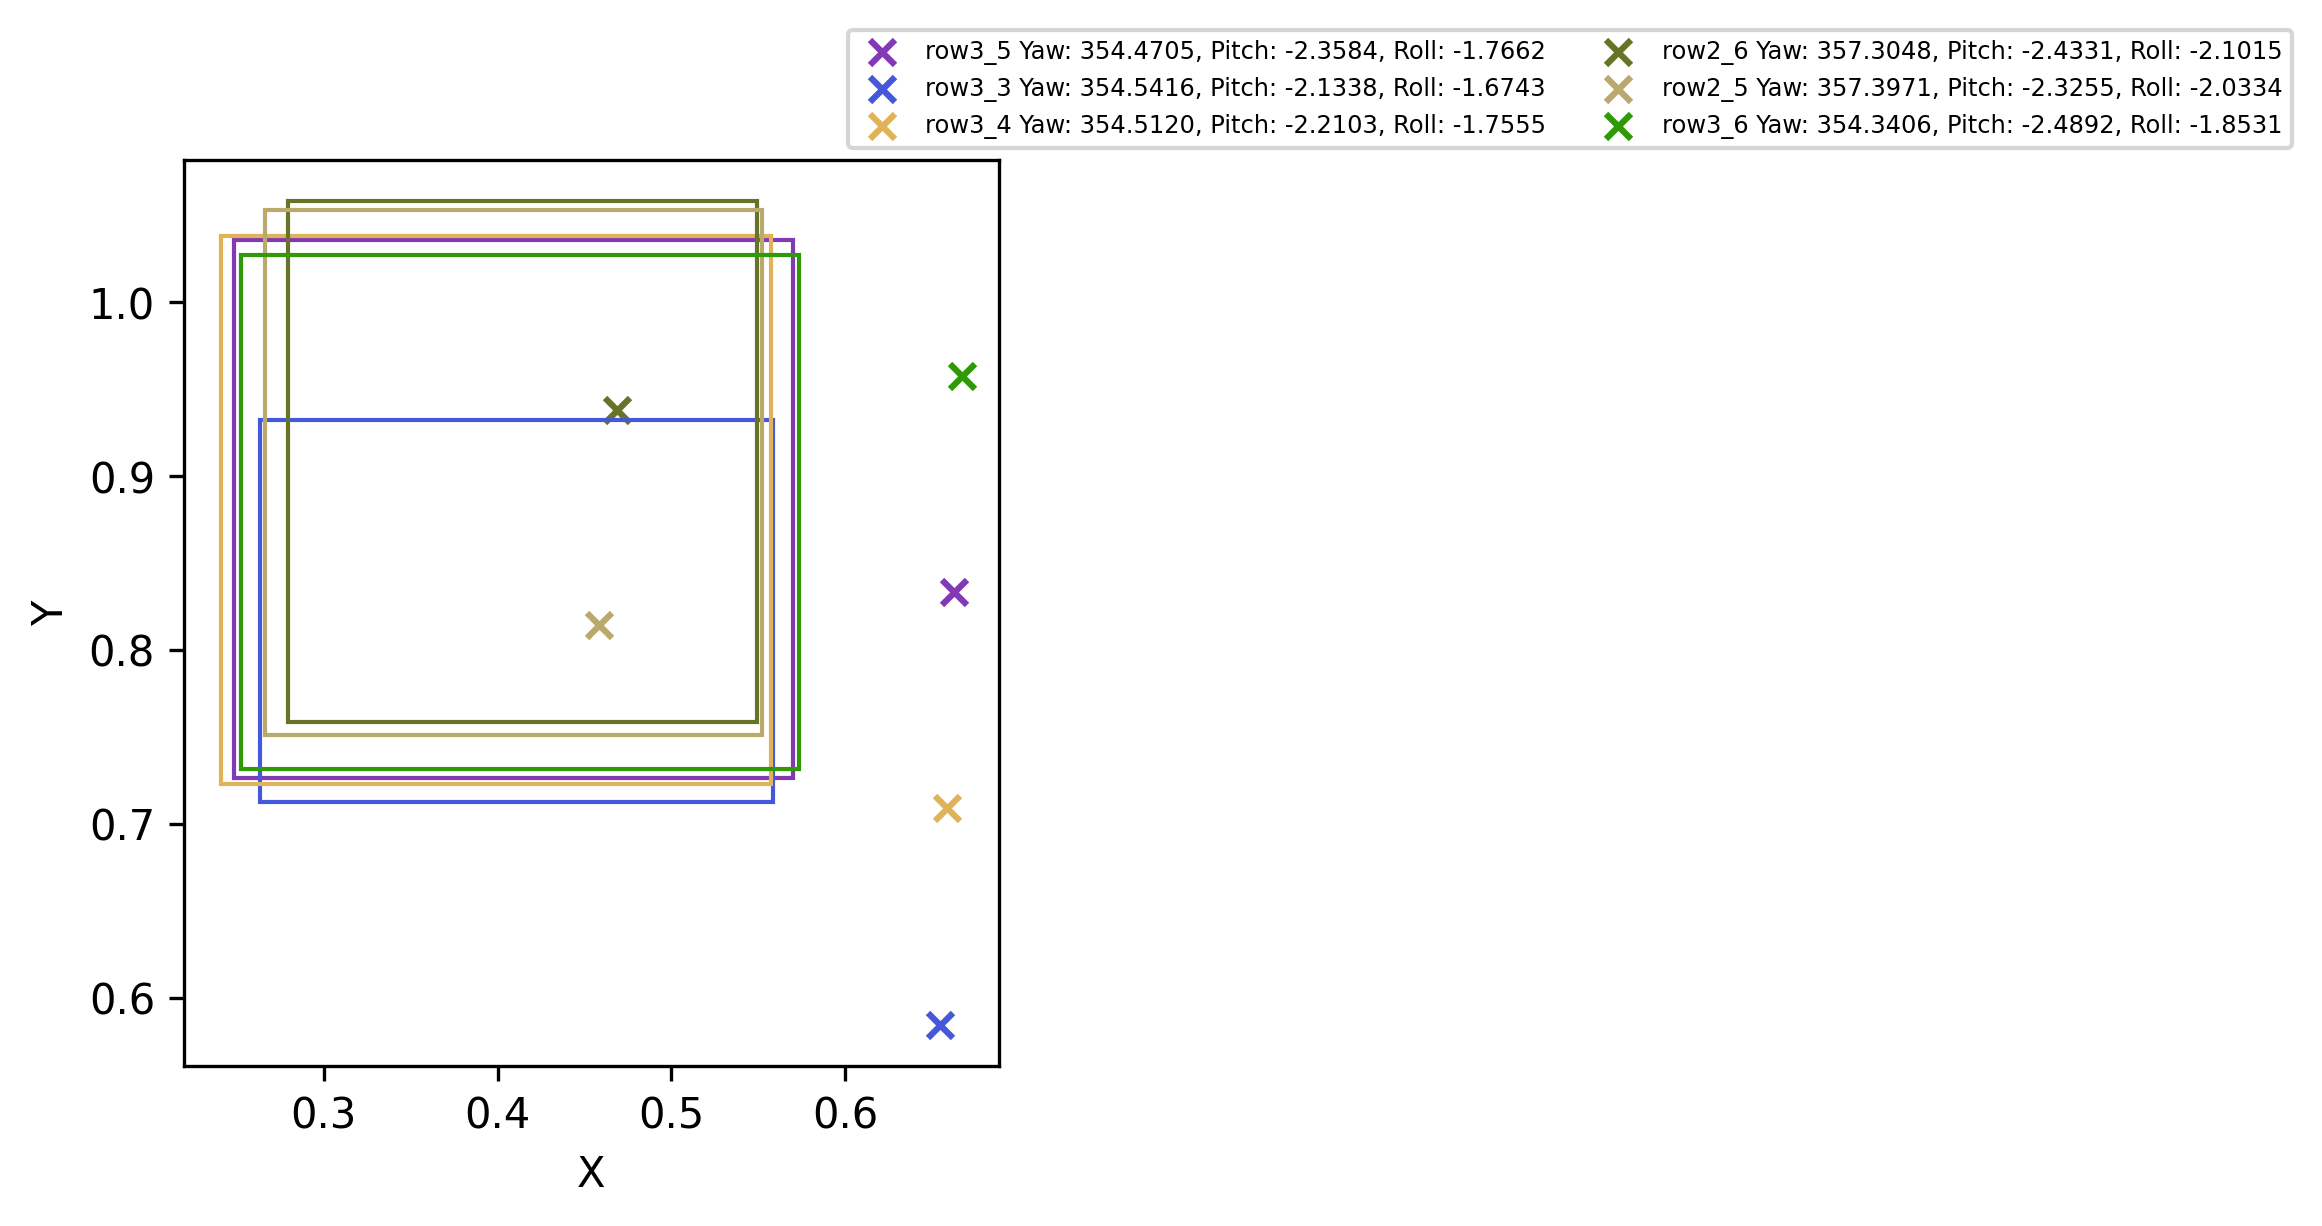

In [27]:
target_to_plot = "target 2"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=None)

IOU - row3_5, row4_6: 0.918349155014237
IOU - row3_5, row4_3: 0.41273724569937836
IOU - row3_5, row3_3: 0.6601249659340839
IOU - row3_5, row4_4: 0.8916001785671951
IOU - row3_5, row3_4: 0.8653794579722577
IOU - row3_5, row2_6: 0.8499269815455809
IOU - row3_5, row2_5: 0.883601946684385
IOU - row3_5, row4_5: 0.9525662360562028
IOU - row3_5, row3_6: 0.9423537696491868
IOU - row4_6, row4_3: 0.40825952743238836
IOU - row4_6, row3_3: 0.6391230745643571
IOU - row4_6, row4_4: 0.8548871353971724
IOU - row4_6, row3_4: 0.7981615396585019
IOU - row4_6, row2_6: 0.8047512566993146
IOU - row4_6, row2_5: 0.8605304911832372
IOU - row4_6, row4_5: 0.9324319318447992
IOU - row4_6, row3_6: 0.8790008766448462
IOU - row4_3, row3_3: 0.6229303455047439
IOU - row4_3, row4_4: 0.4624926886944982
IOU - row4_3, row3_4: 0.39181352516256573
IOU - row4_3, row2_6: 0.35243566916759195
IOU - row4_3, row2_5: 0.3784108442631015
IOU - row4_3, row4_5: 0.43063927333589247
IOU - row4_3, row3_6: 0.390788351898161
IOU - row3_3, 

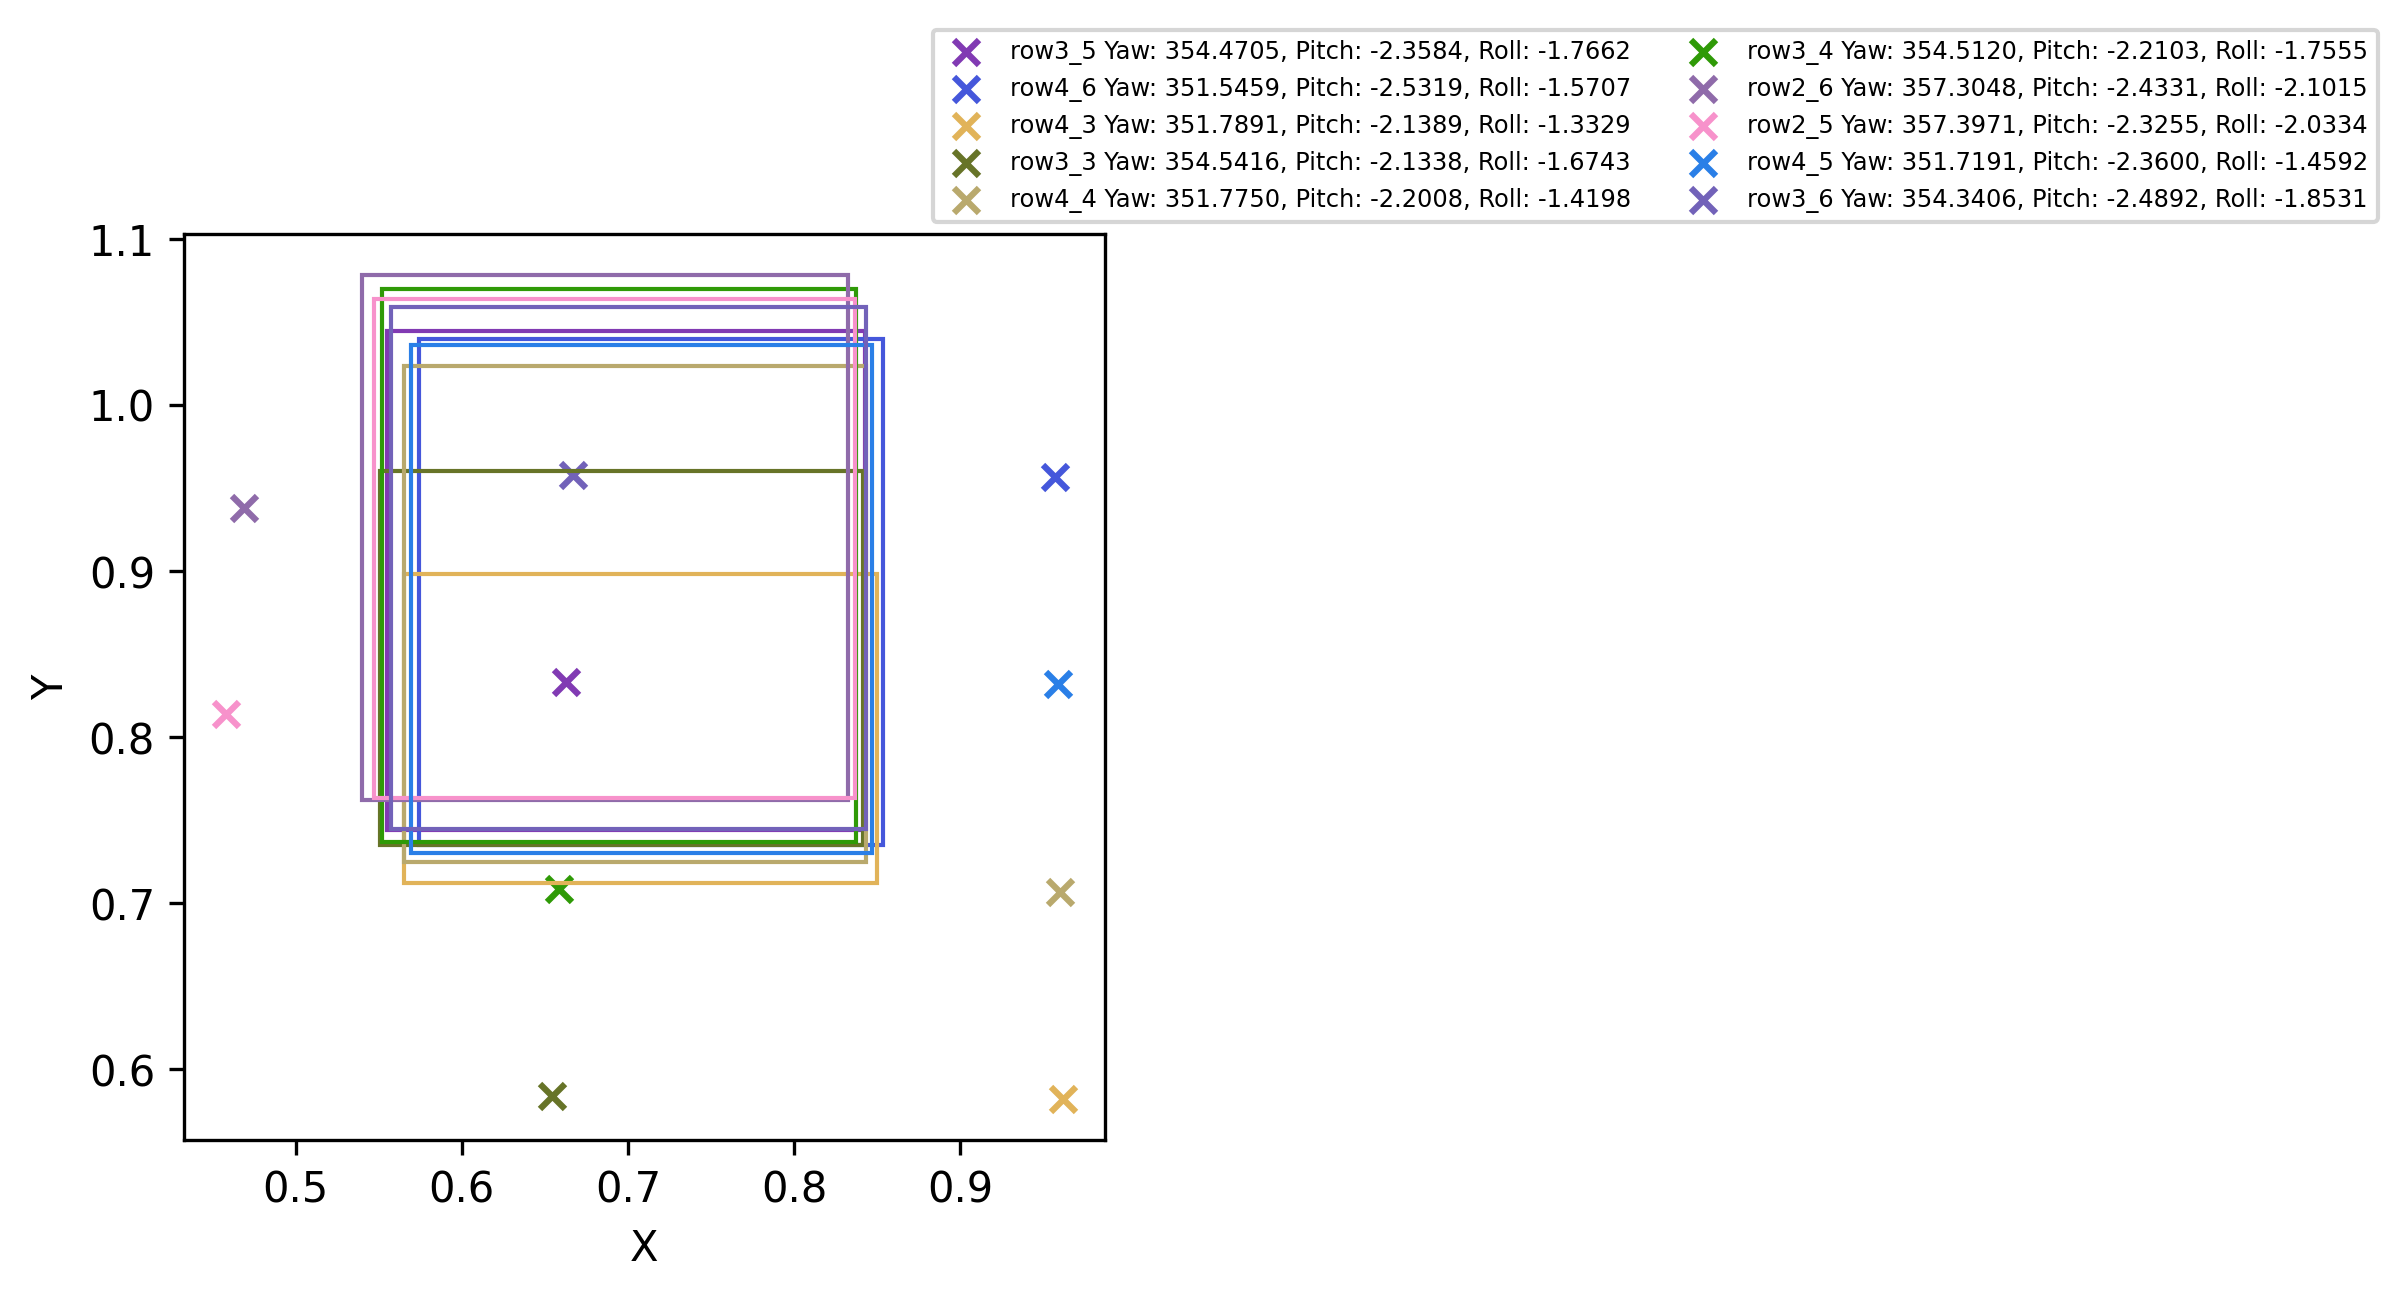

In [28]:
target_to_plot = "target 3"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=None)

IOU - row5_6, row3_5: 0.8395332454337827
IOU - row5_6, row4_6: 0.8551880393057059
IOU - row5_6, row4_3: 0.5721095153034755
IOU - row5_6, row3_3: 0.770178182319741
IOU - row5_6, row5_5: 0.8375416464186453
IOU - row5_6, row5_4: 0.6329514389162184
IOU - row5_6, row4_4: 0.8632019192363007
IOU - row5_6, row3_4: 0.8329776313682469
IOU - row5_6, row2_6: 0.6437349540213946
IOU - row5_6, row2_5: 0.6100768929611816
IOU - row5_6, row4_5: 0.83779723836898
IOU - row5_6, row3_6: 0.851253302473841
IOU - row3_5, row4_6: 0.9493317391093403
IOU - row3_5, row4_3: 0.595742848996424
IOU - row3_5, row3_3: 0.7949323974246066
IOU - row3_5, row5_5: 0.8391517576974292
IOU - row3_5, row5_4: 0.6597414491339717
IOU - row3_5, row4_4: 0.850040591698905
IOU - row3_5, row3_4: 0.9615992810793447
IOU - row3_5, row2_6: 0.7476503295281556
IOU - row3_5, row2_5: 0.700595413471171
IOU - row3_5, row4_5: 0.8473301394572955
IOU - row3_5, row3_6: 0.9711257608961266
IOU - row4_6, row4_3: 0.6225742963003227
IOU - row4_6, row3_3: 0

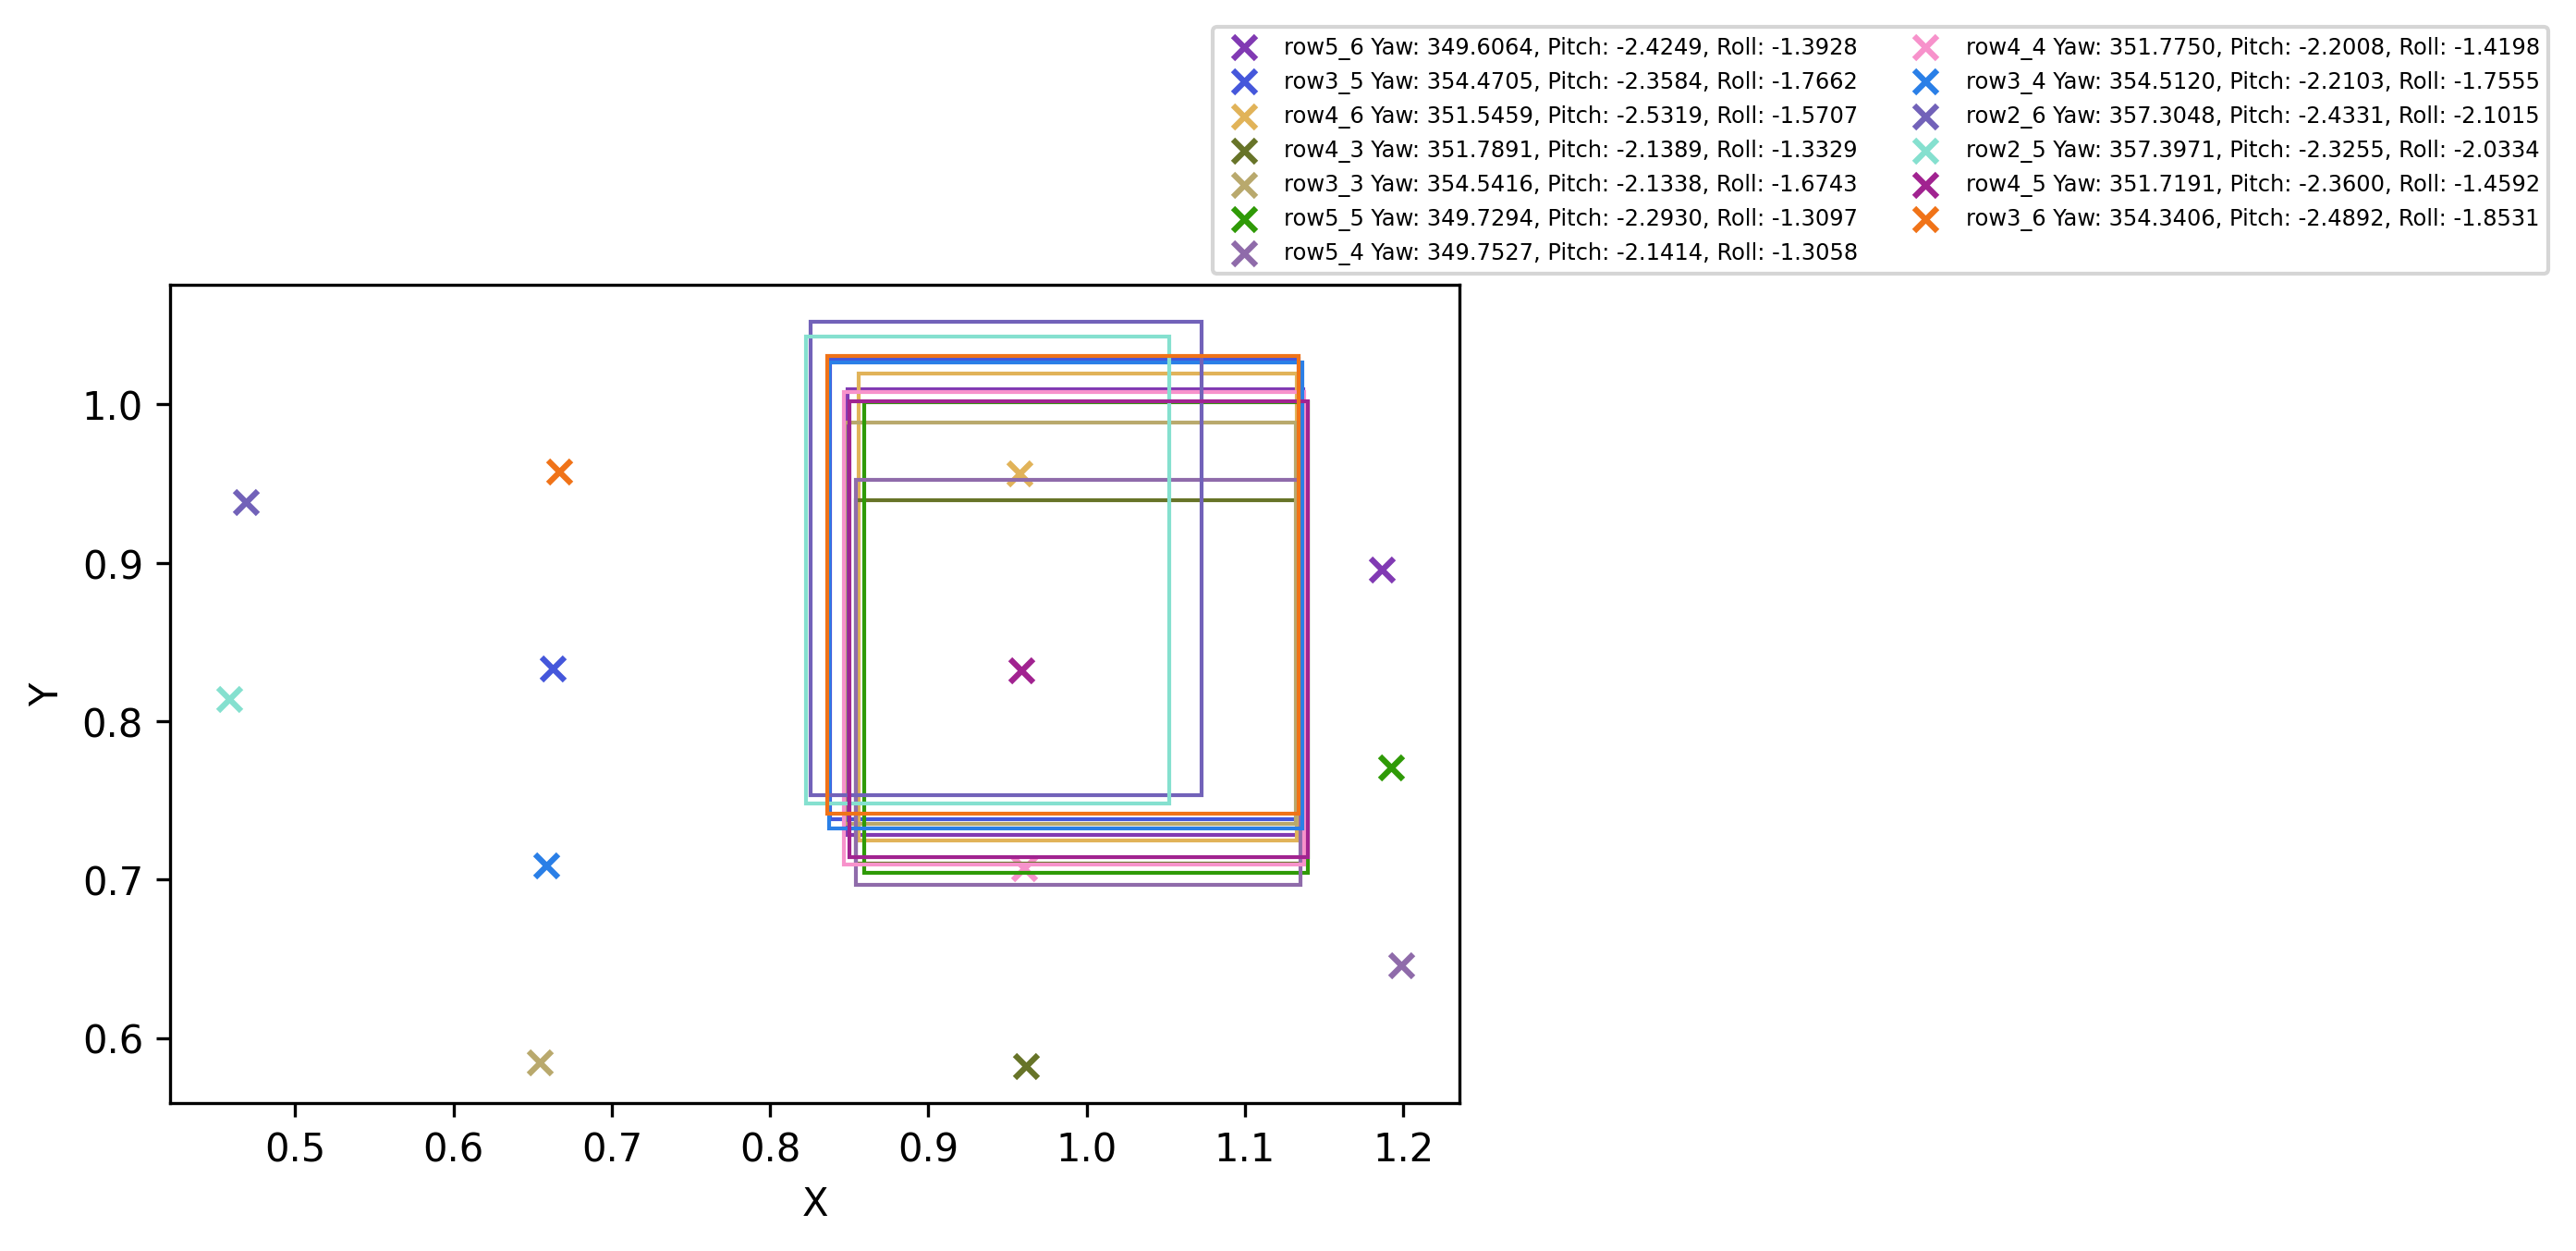

In [29]:
target_to_plot = "target 4"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=None)

IOU - row3_5, row3_3: 0.7595380869383453
IOU - row3_5, row3_1: 0.5544428627102752
IOU - row3_5, row3_4: 0.7616775668767075
IOU - row3_5, row2_5: 0.8611232544623476
IOU - row3_3, row3_1: 0.7503048794518964
IOU - row3_3, row3_4: 0.9304521051898579
IOU - row3_3, row2_5: 0.664684148093882
IOU - row3_1, row3_4: 0.6951249693027653
IOU - row3_1, row2_5: 0.5144099754449974
IOU - row3_4, row2_5: 0.6700209708399296


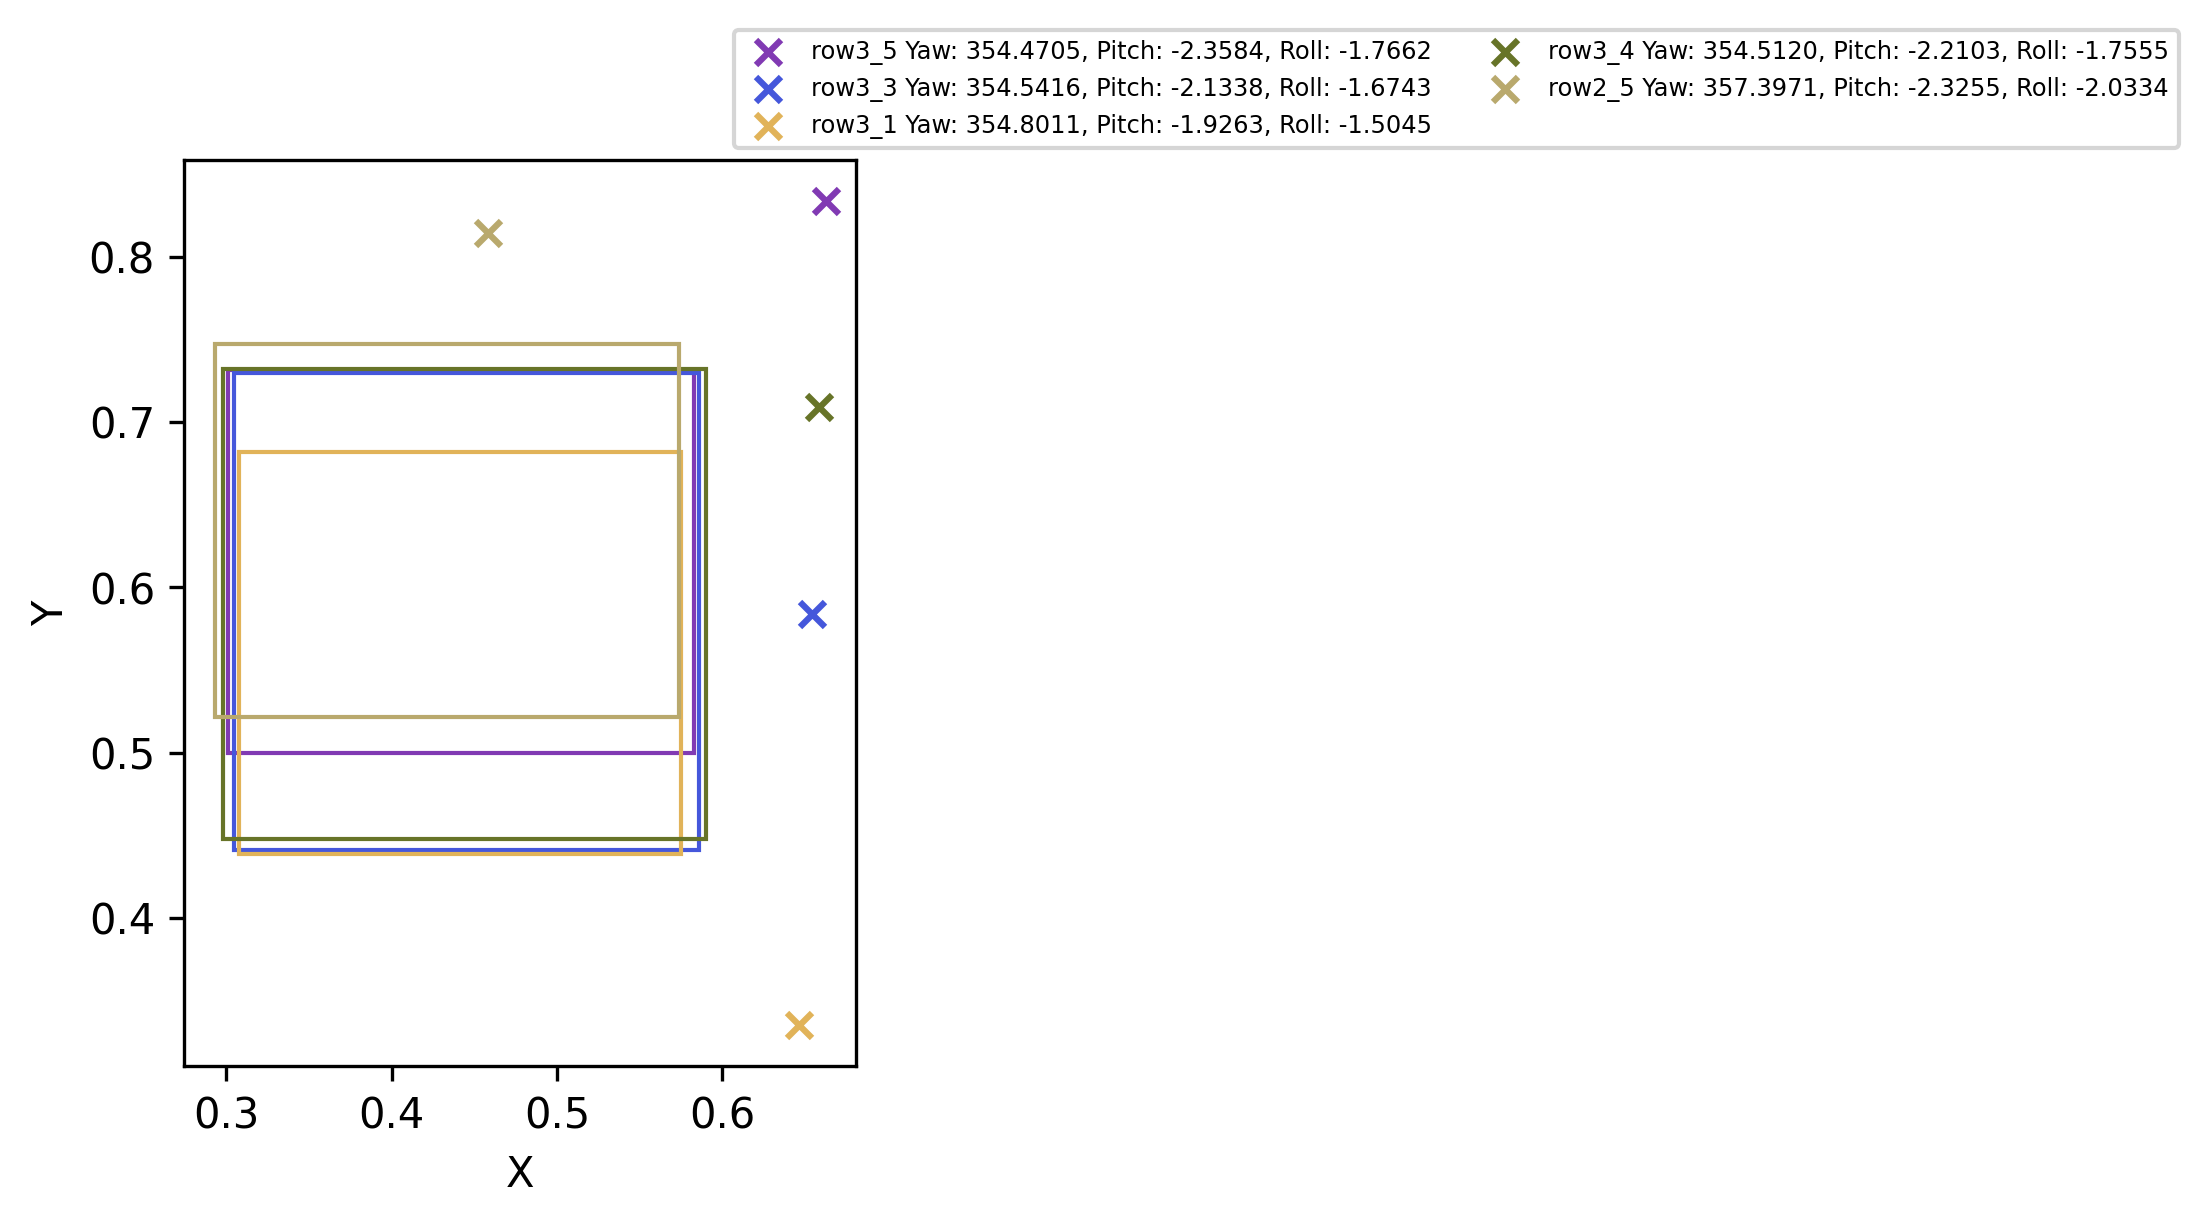

In [30]:
target_to_plot = "target 5"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=None)

IOU - row4_2, row5_6: 0.2604028012750299
IOU - row4_2, row3_5: 0.5757552726626495
IOU - row4_2, row4_6: 0.2780143260400747
IOU - row4_2, row4_3: 0.9227086109628521
IOU - row4_2, row3_3: 0.8690790767810879
IOU - row4_2, row5_5: 0.38625410371614405
IOU - row4_2, row5_4: 0.4284527001130323
IOU - row4_2, row4_4: 0.8987039641176106
IOU - row4_2, row3_1: 0.8783021642167654
IOU - row4_2, row5_2: 0.4438766937707386
IOU - row4_2, row3_4: 0.8460079787157668
IOU - row4_2, row2_5: 0.5543318199977232
IOU - row4_2, row5_3: 0.5116175031651123
IOU - row4_2, row4_5: 0.7672626700286223
IOU - row5_6, row3_5: 0.27728072241123525
IOU - row5_6, row4_6: 0.216620707018721
IOU - row5_6, row4_3: 0.26382766077830266
IOU - row5_6, row3_3: 0.25891484963338757
IOU - row5_6, row5_5: 0.6465949899589866
IOU - row5_6, row5_4: 0.5649399264351092
IOU - row5_6, row4_4: 0.2817515732649207
IOU - row5_6, row3_1: 0.24432773411556502
IOU - row5_6, row5_2: 0.39475756058471767
IOU - row5_6, row3_4: 0.24503555044659348
IOU - row5

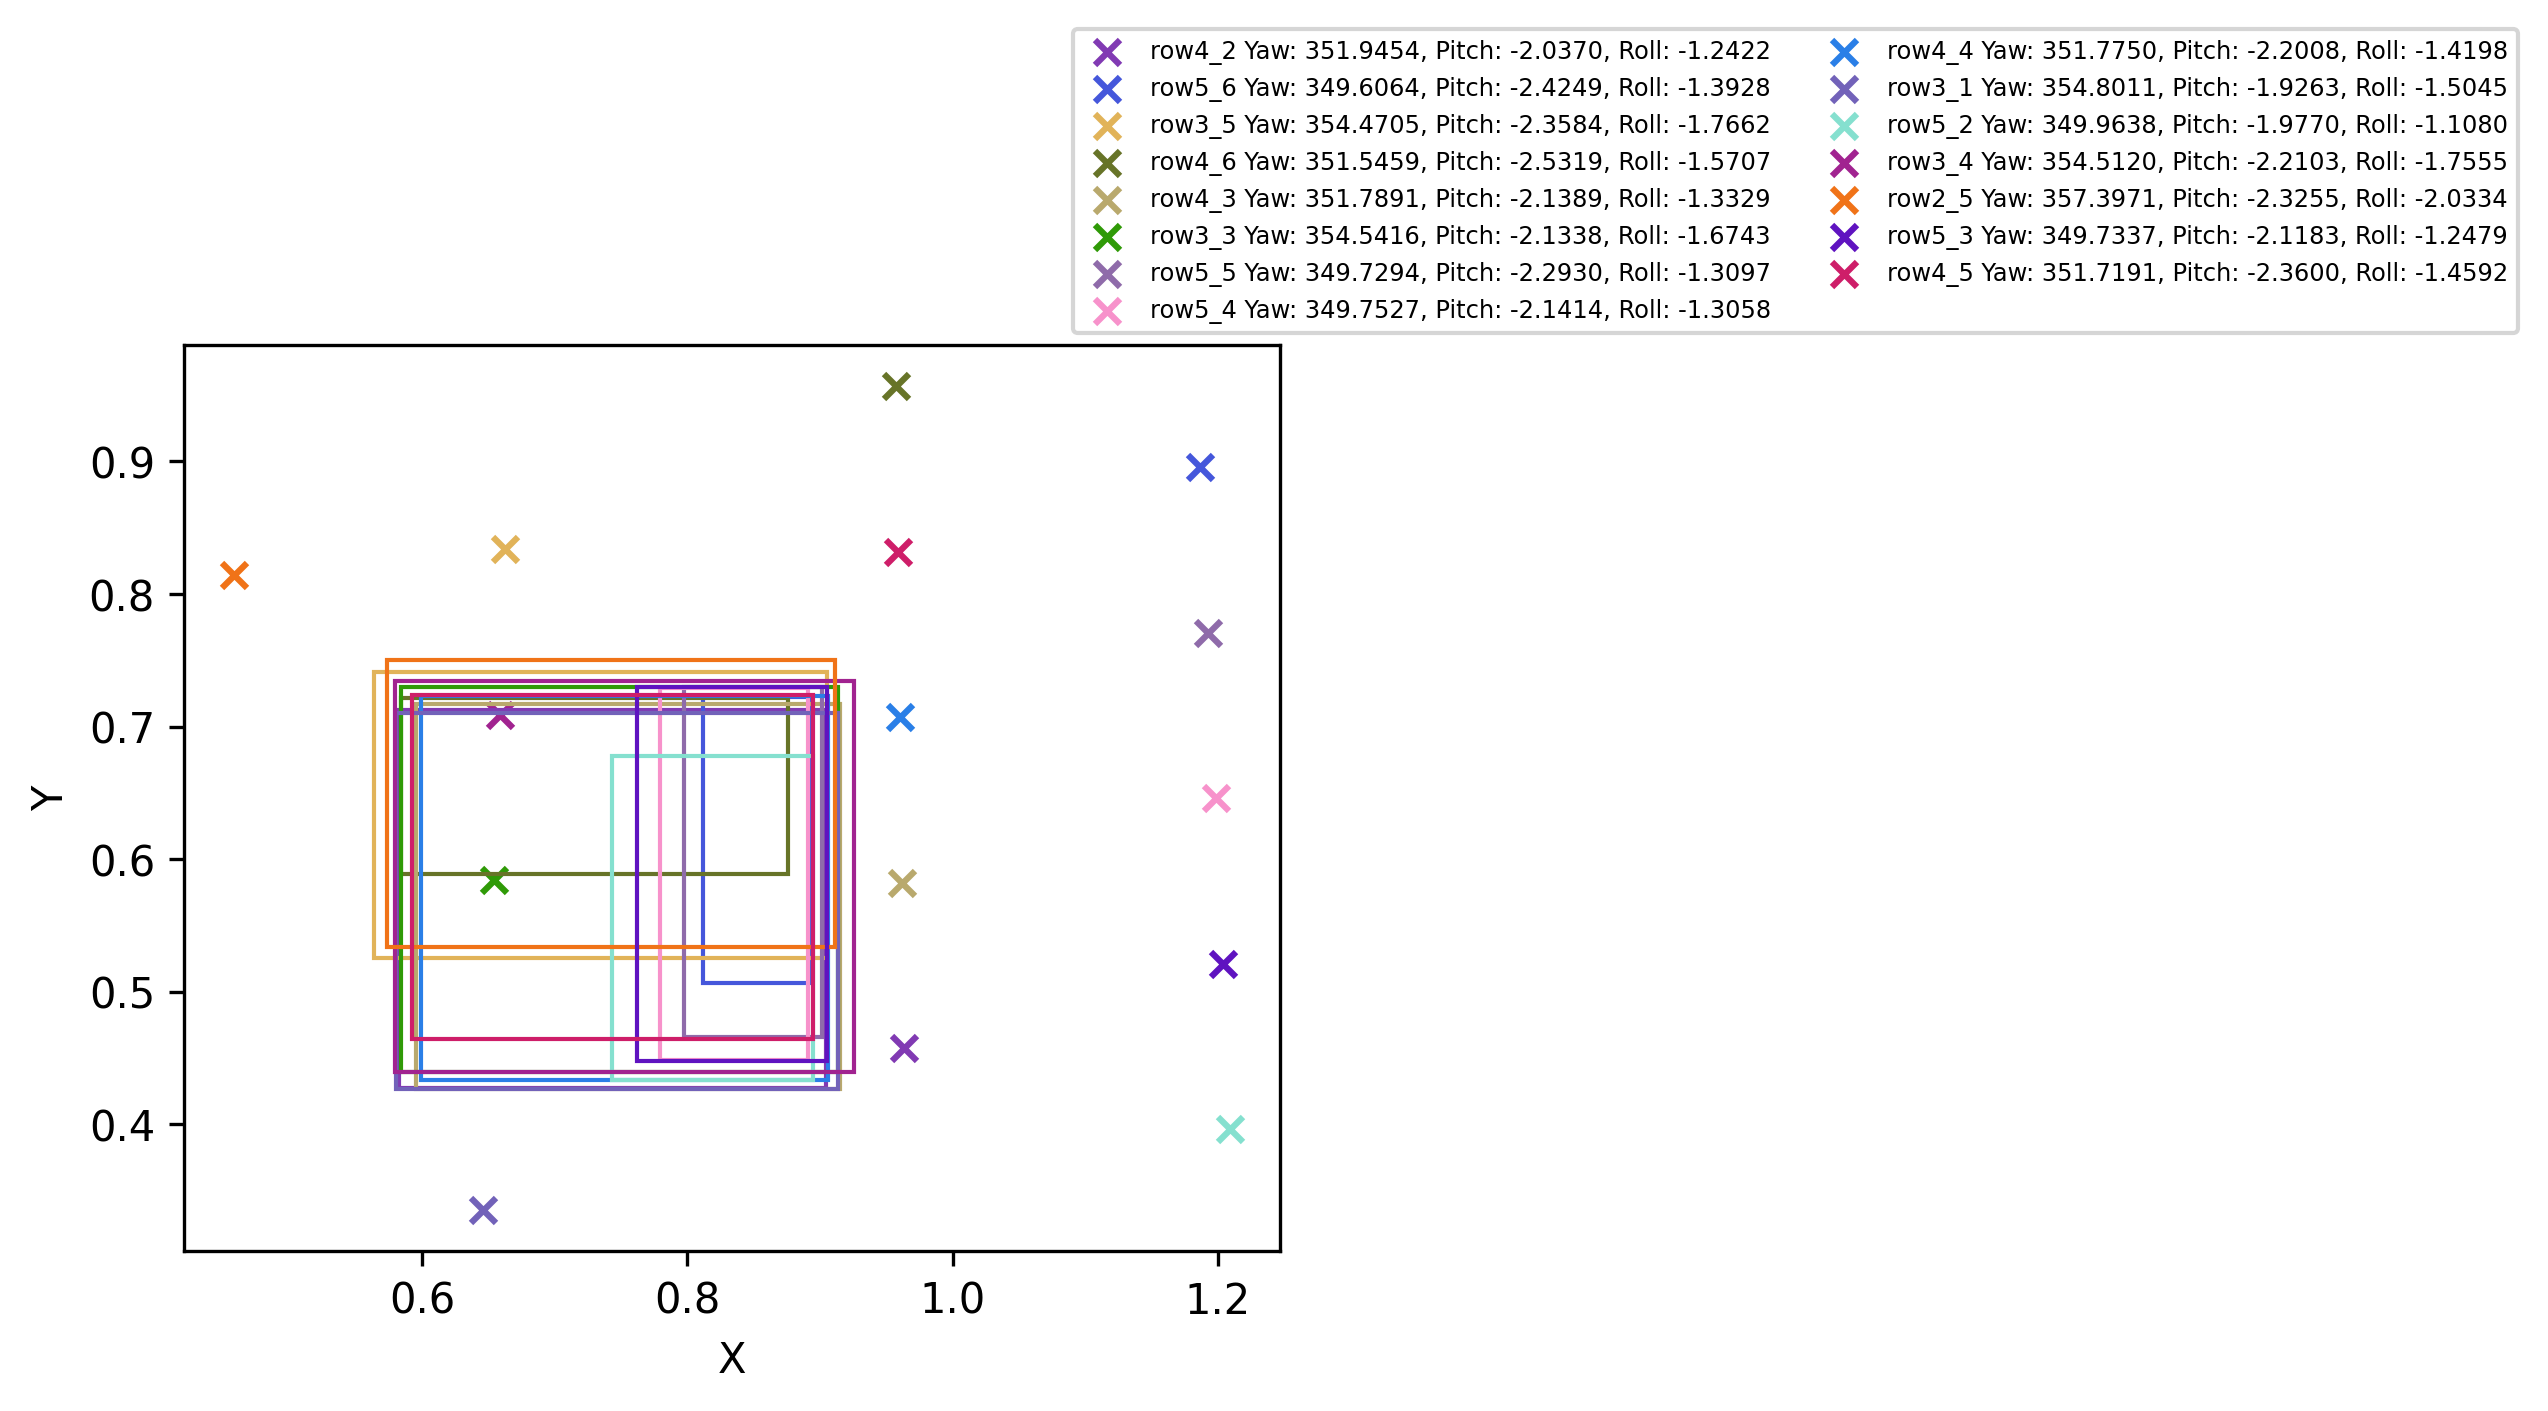

In [31]:
target_to_plot = "target 6"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=None)

IOU - row3_3, row3_1: 0.6154036736068331


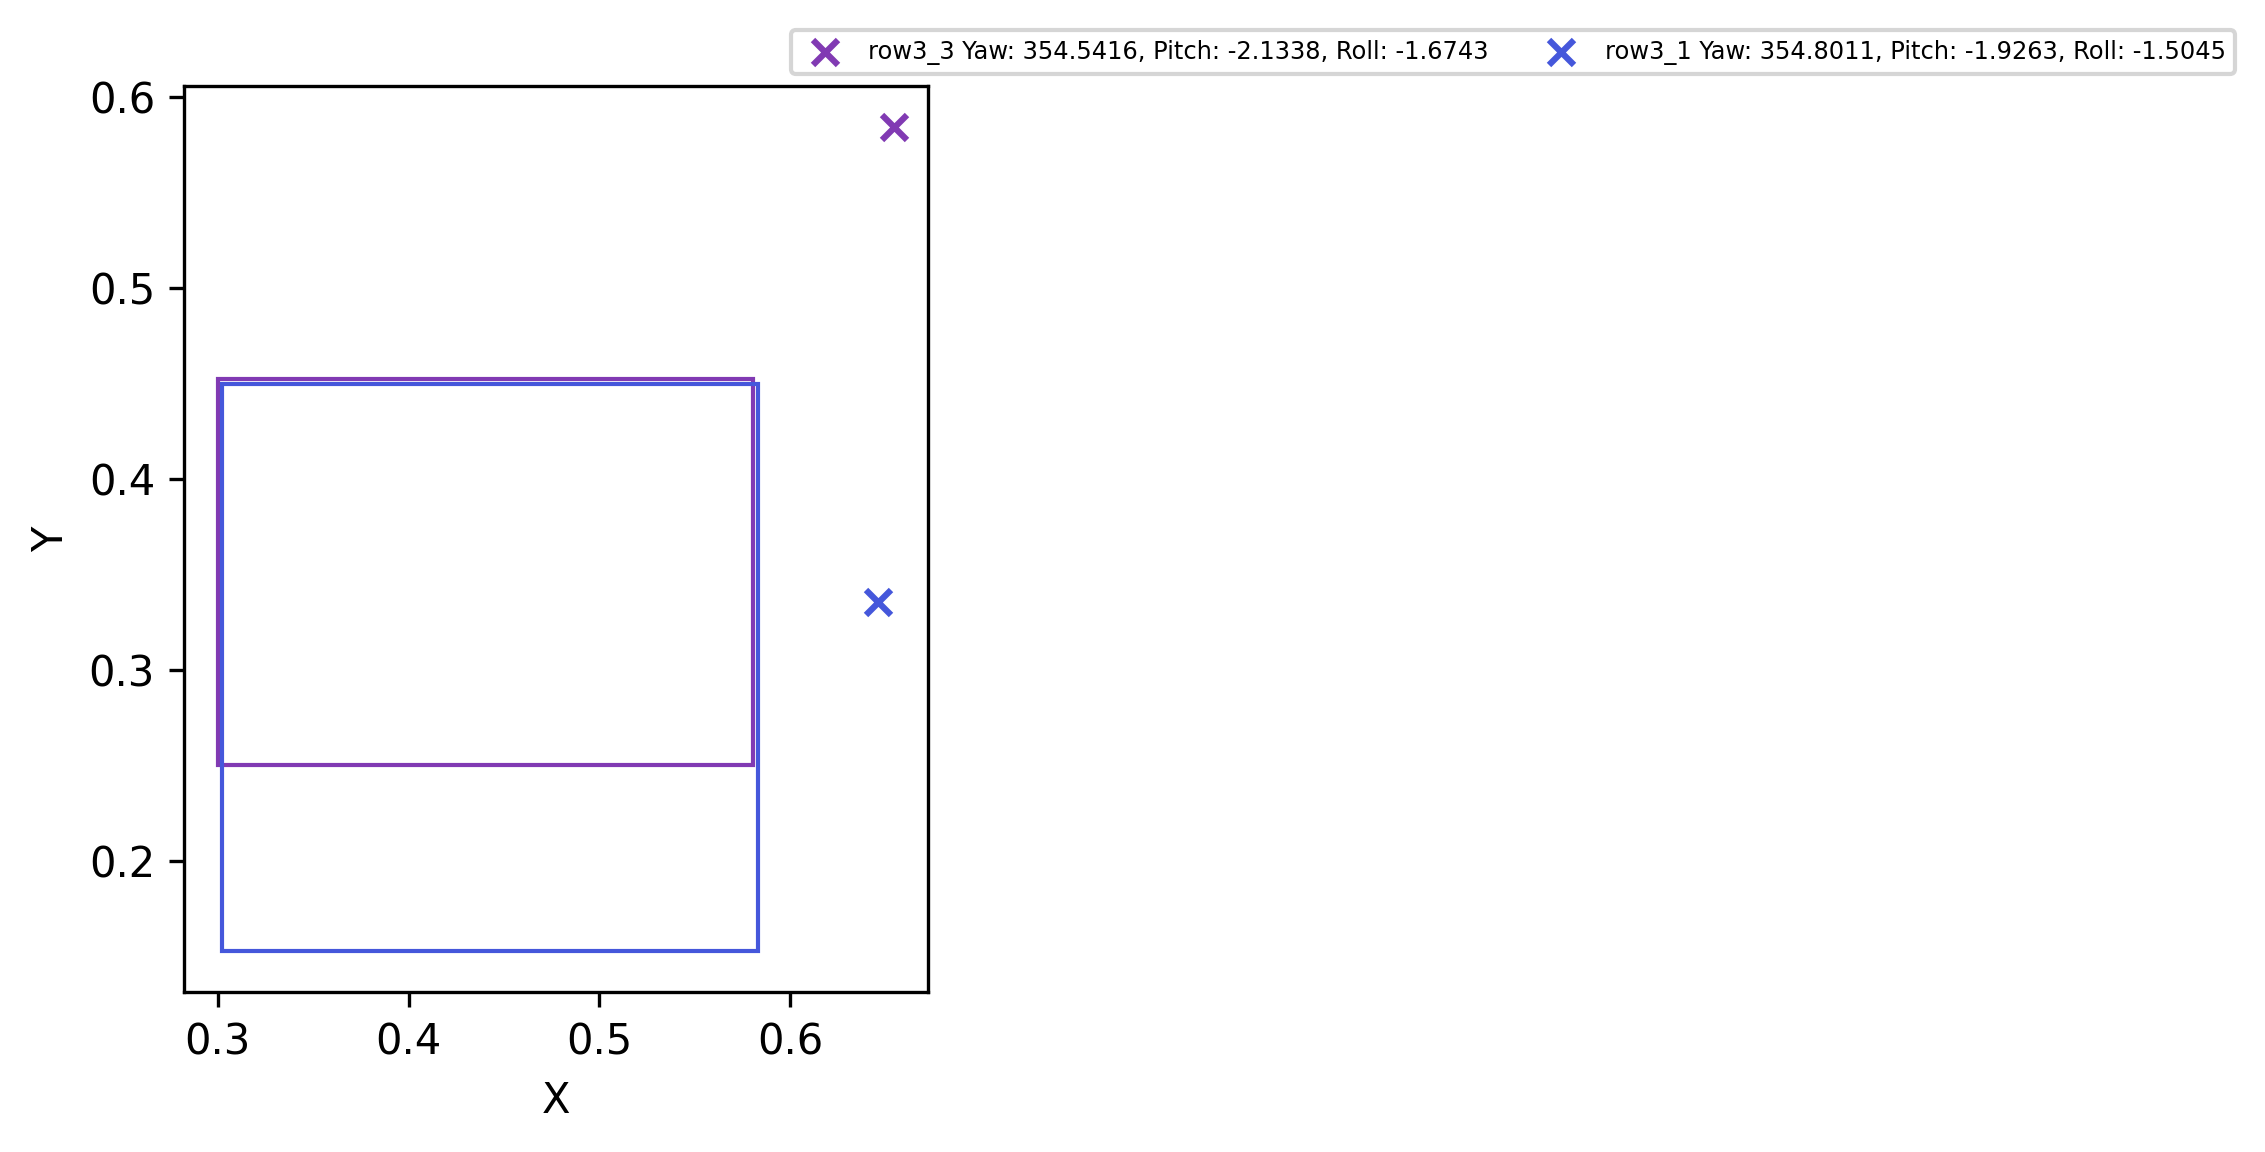

In [33]:
target_to_plot = "target 7"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=None)

IOU - row4_2, row4_3: 0.5332148475654681
IOU - row4_2, row3_3: 0.36810972297463174
IOU - row4_2, row3_1: 0.8939818191078868
IOU - row4_3, row3_3: 0.49684488677095257
IOU - row4_3, row3_1: 0.54791658857306
IOU - row3_3, row3_1: 0.4252686231847889


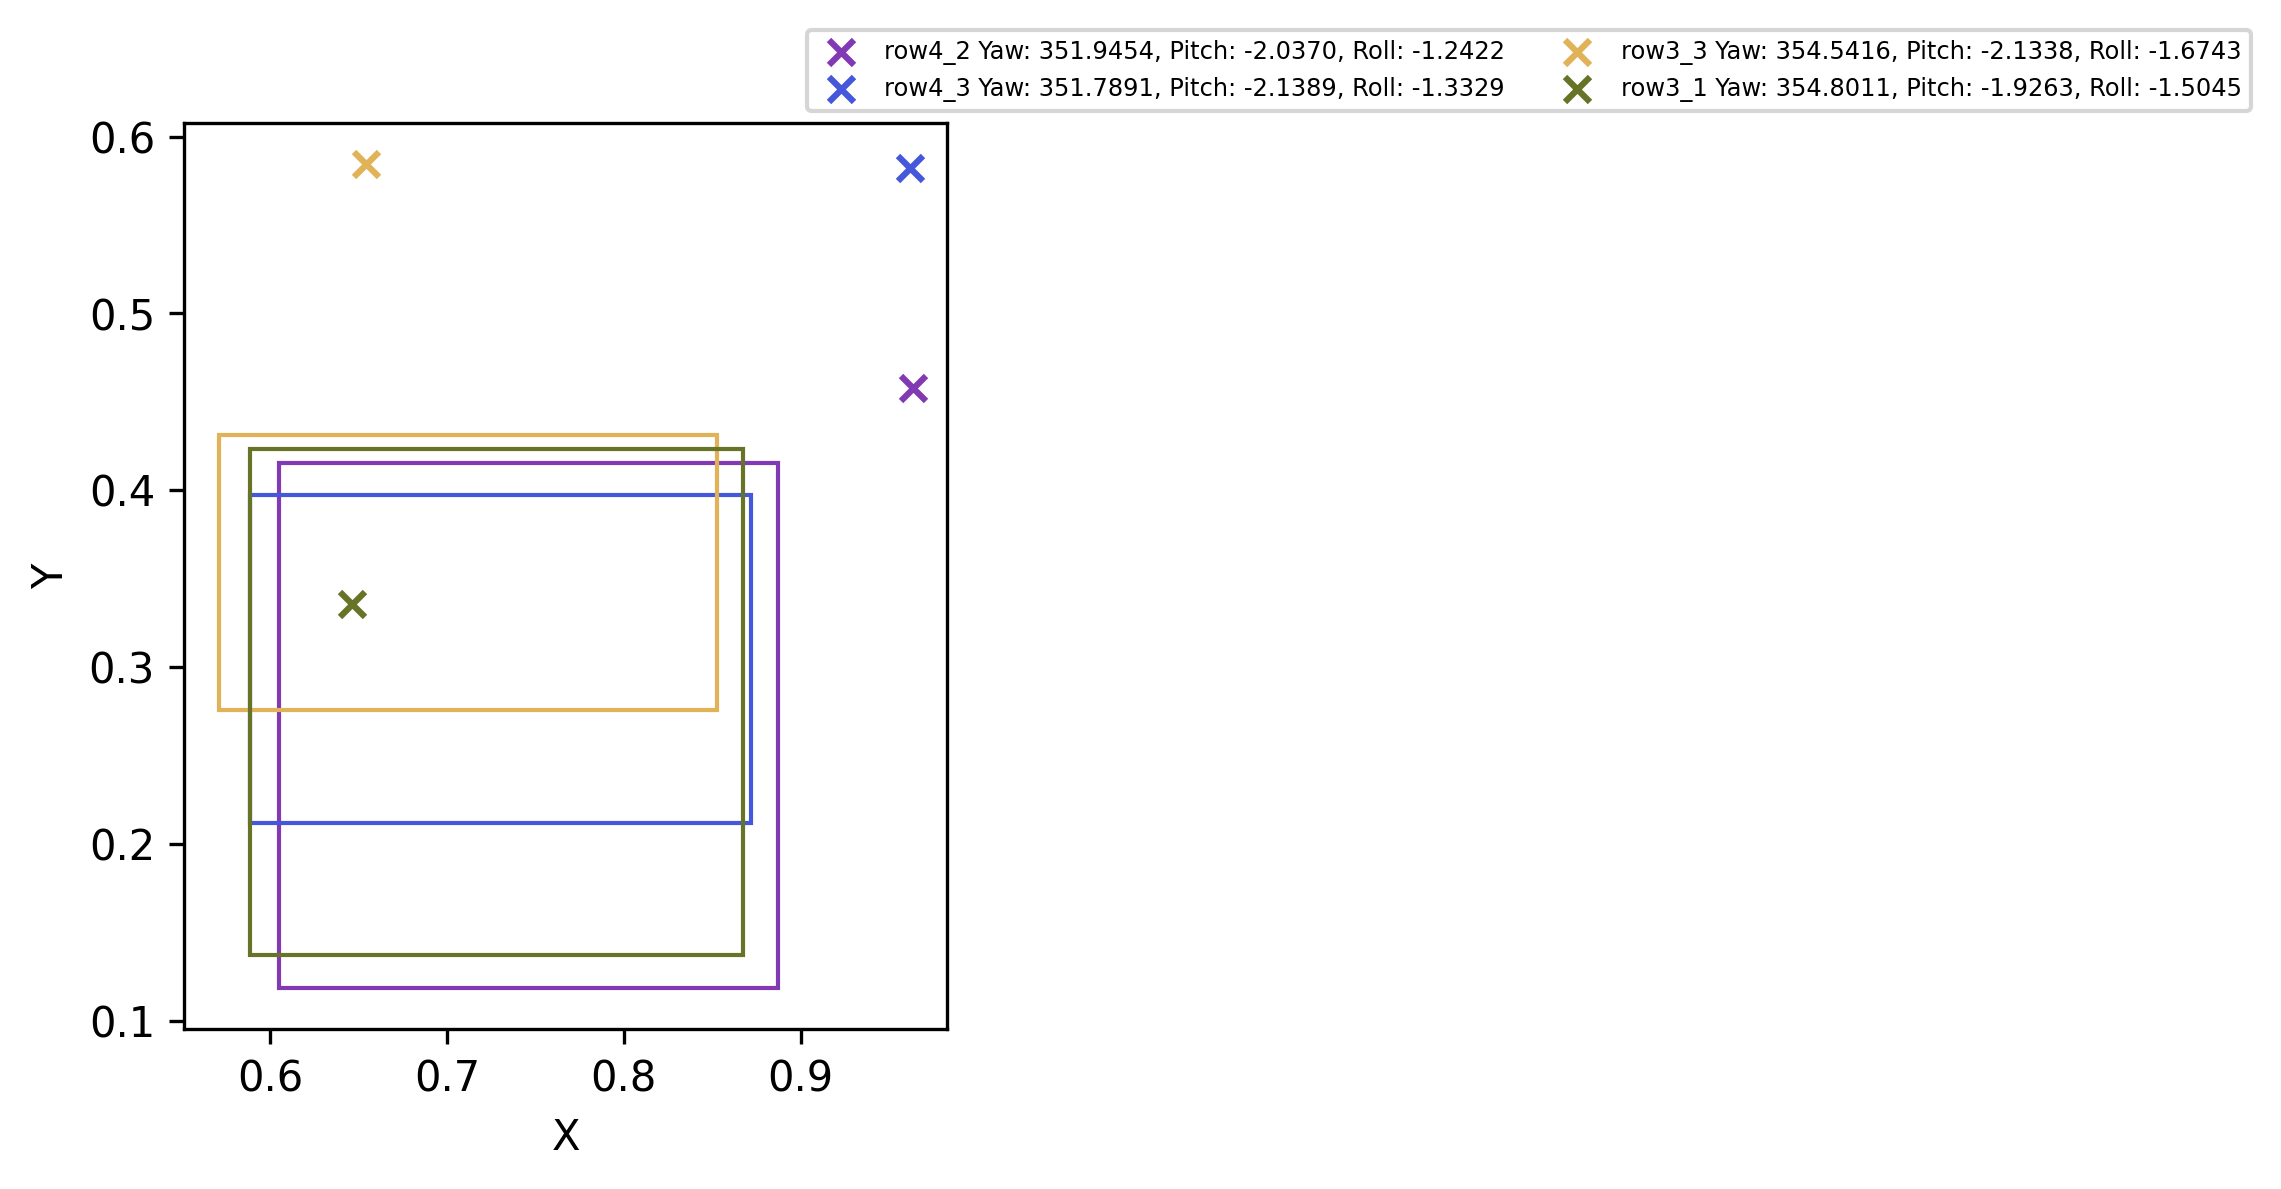

In [34]:
target_to_plot = "target 8"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=None)

IOU - row4_2, row5_6: 0.4859262040264545
IOU - row4_2, row5_1: 0.3979130747571762
IOU - row4_2, row3_5: 0.42030288677901767
IOU - row4_2, row4_3: 0.8506666738479705
IOU - row4_2, row3_3: 0.8069864135192445
IOU - row4_2, row5_5: 0.8372231031088502
IOU - row4_2, row5_4: 0.8639350775220841
IOU - row4_2, row4_4: 0.8182742366462582
IOU - row4_2, row3_1: 0.880462354394388
IOU - row4_2, row5_2: 0.8683120398235652
IOU - row4_2, row3_4: 0.8158210334909995
IOU - row4_2, row5_3: 0.8598922612636615
IOU - row4_2, row4_5: 0.5384502852204407
IOU - row5_6, row5_1: 0.04892899572743246
IOU - row5_6, row3_5: 0.7120139102016955
IOU - row5_6, row4_3: 0.5451884993950589
IOU - row5_6, row3_3: 0.4771141517327078
IOU - row5_6, row5_5: 0.5740512565893934
IOU - row5_6, row5_4: 0.5436960688777633
IOU - row5_6, row4_4: 0.5504997125633276
IOU - row5_6, row3_1: 0.4579740555013427
IOU - row5_6, row5_2: 0.49769425403376855
IOU - row5_6, row3_4: 0.478239618624094
IOU - row5_6, row5_3: 0.5063444064489445
IOU - row5_6, r

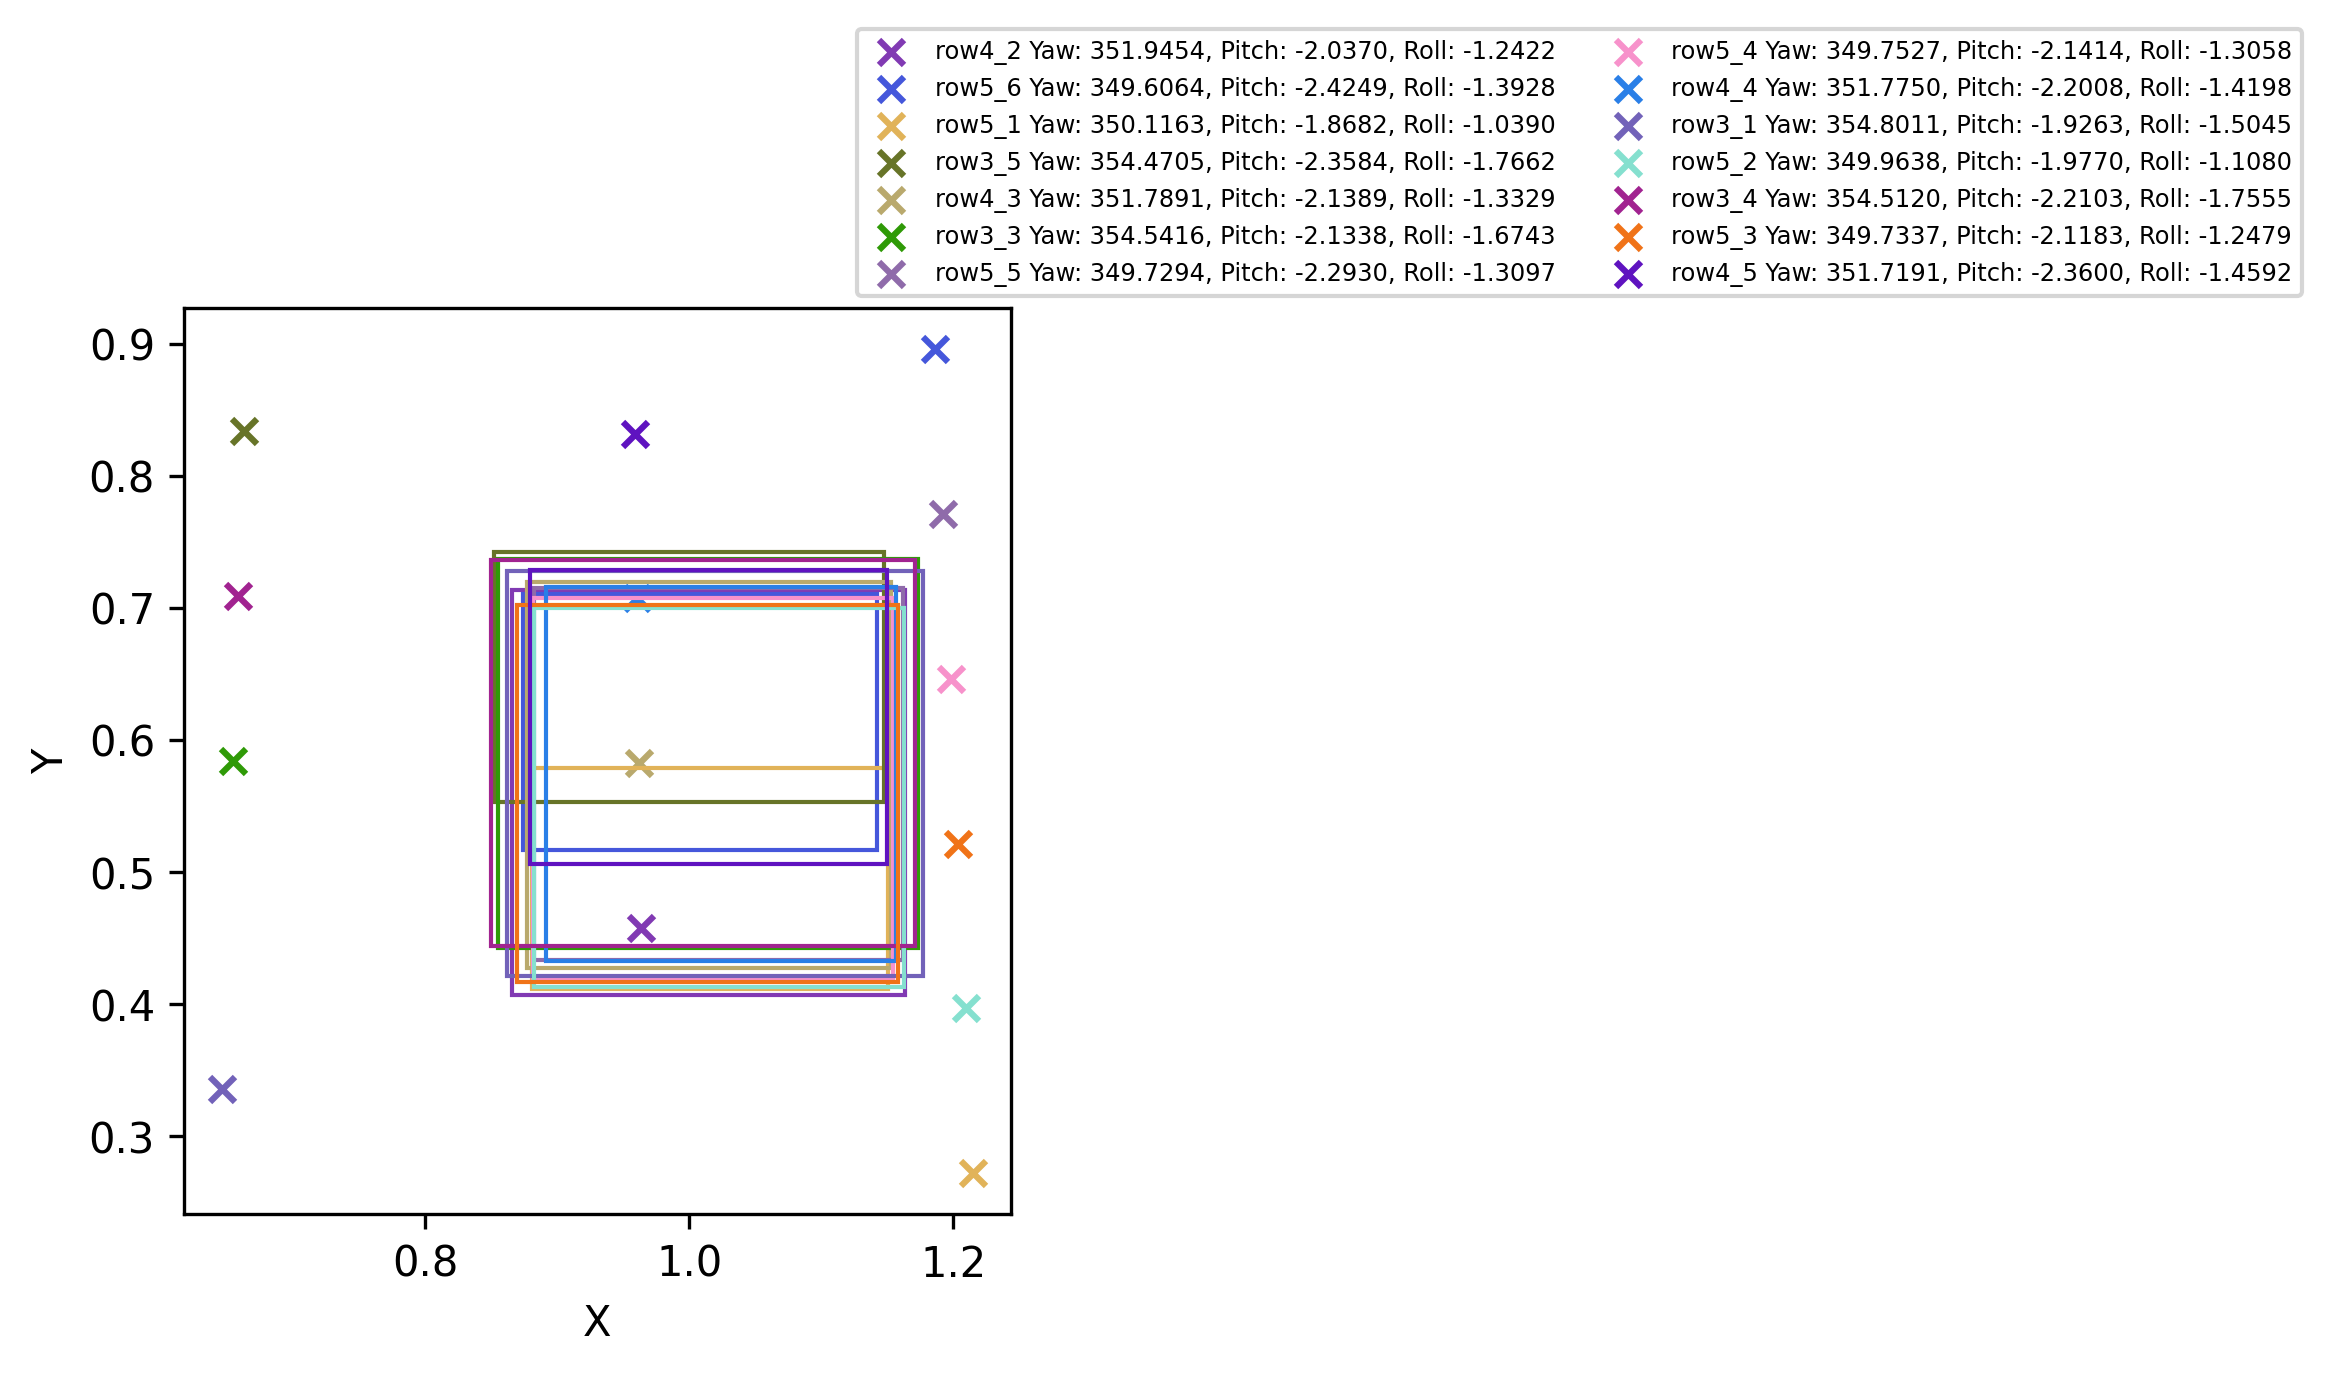

In [35]:
target_to_plot = "target 9"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=None)

IOU - row4_2, row5_1: 0.8696081242821306
IOU - row4_2, row4_3: 0.5153597219584283
IOU - row4_2, row3_3: 0.34995781461196035
IOU - row4_2, row3_1: 0.8079575438753535
IOU - row5_1, row4_3: 0.45982825161820334
IOU - row5_1, row3_3: 0.3000318723481894
IOU - row5_1, row3_1: 0.7873470626881783
IOU - row4_3, row3_3: 0.6058811728592751
IOU - row4_3, row3_1: 0.4270421940095152
IOU - row3_3, row3_1: 0.3852009247076898


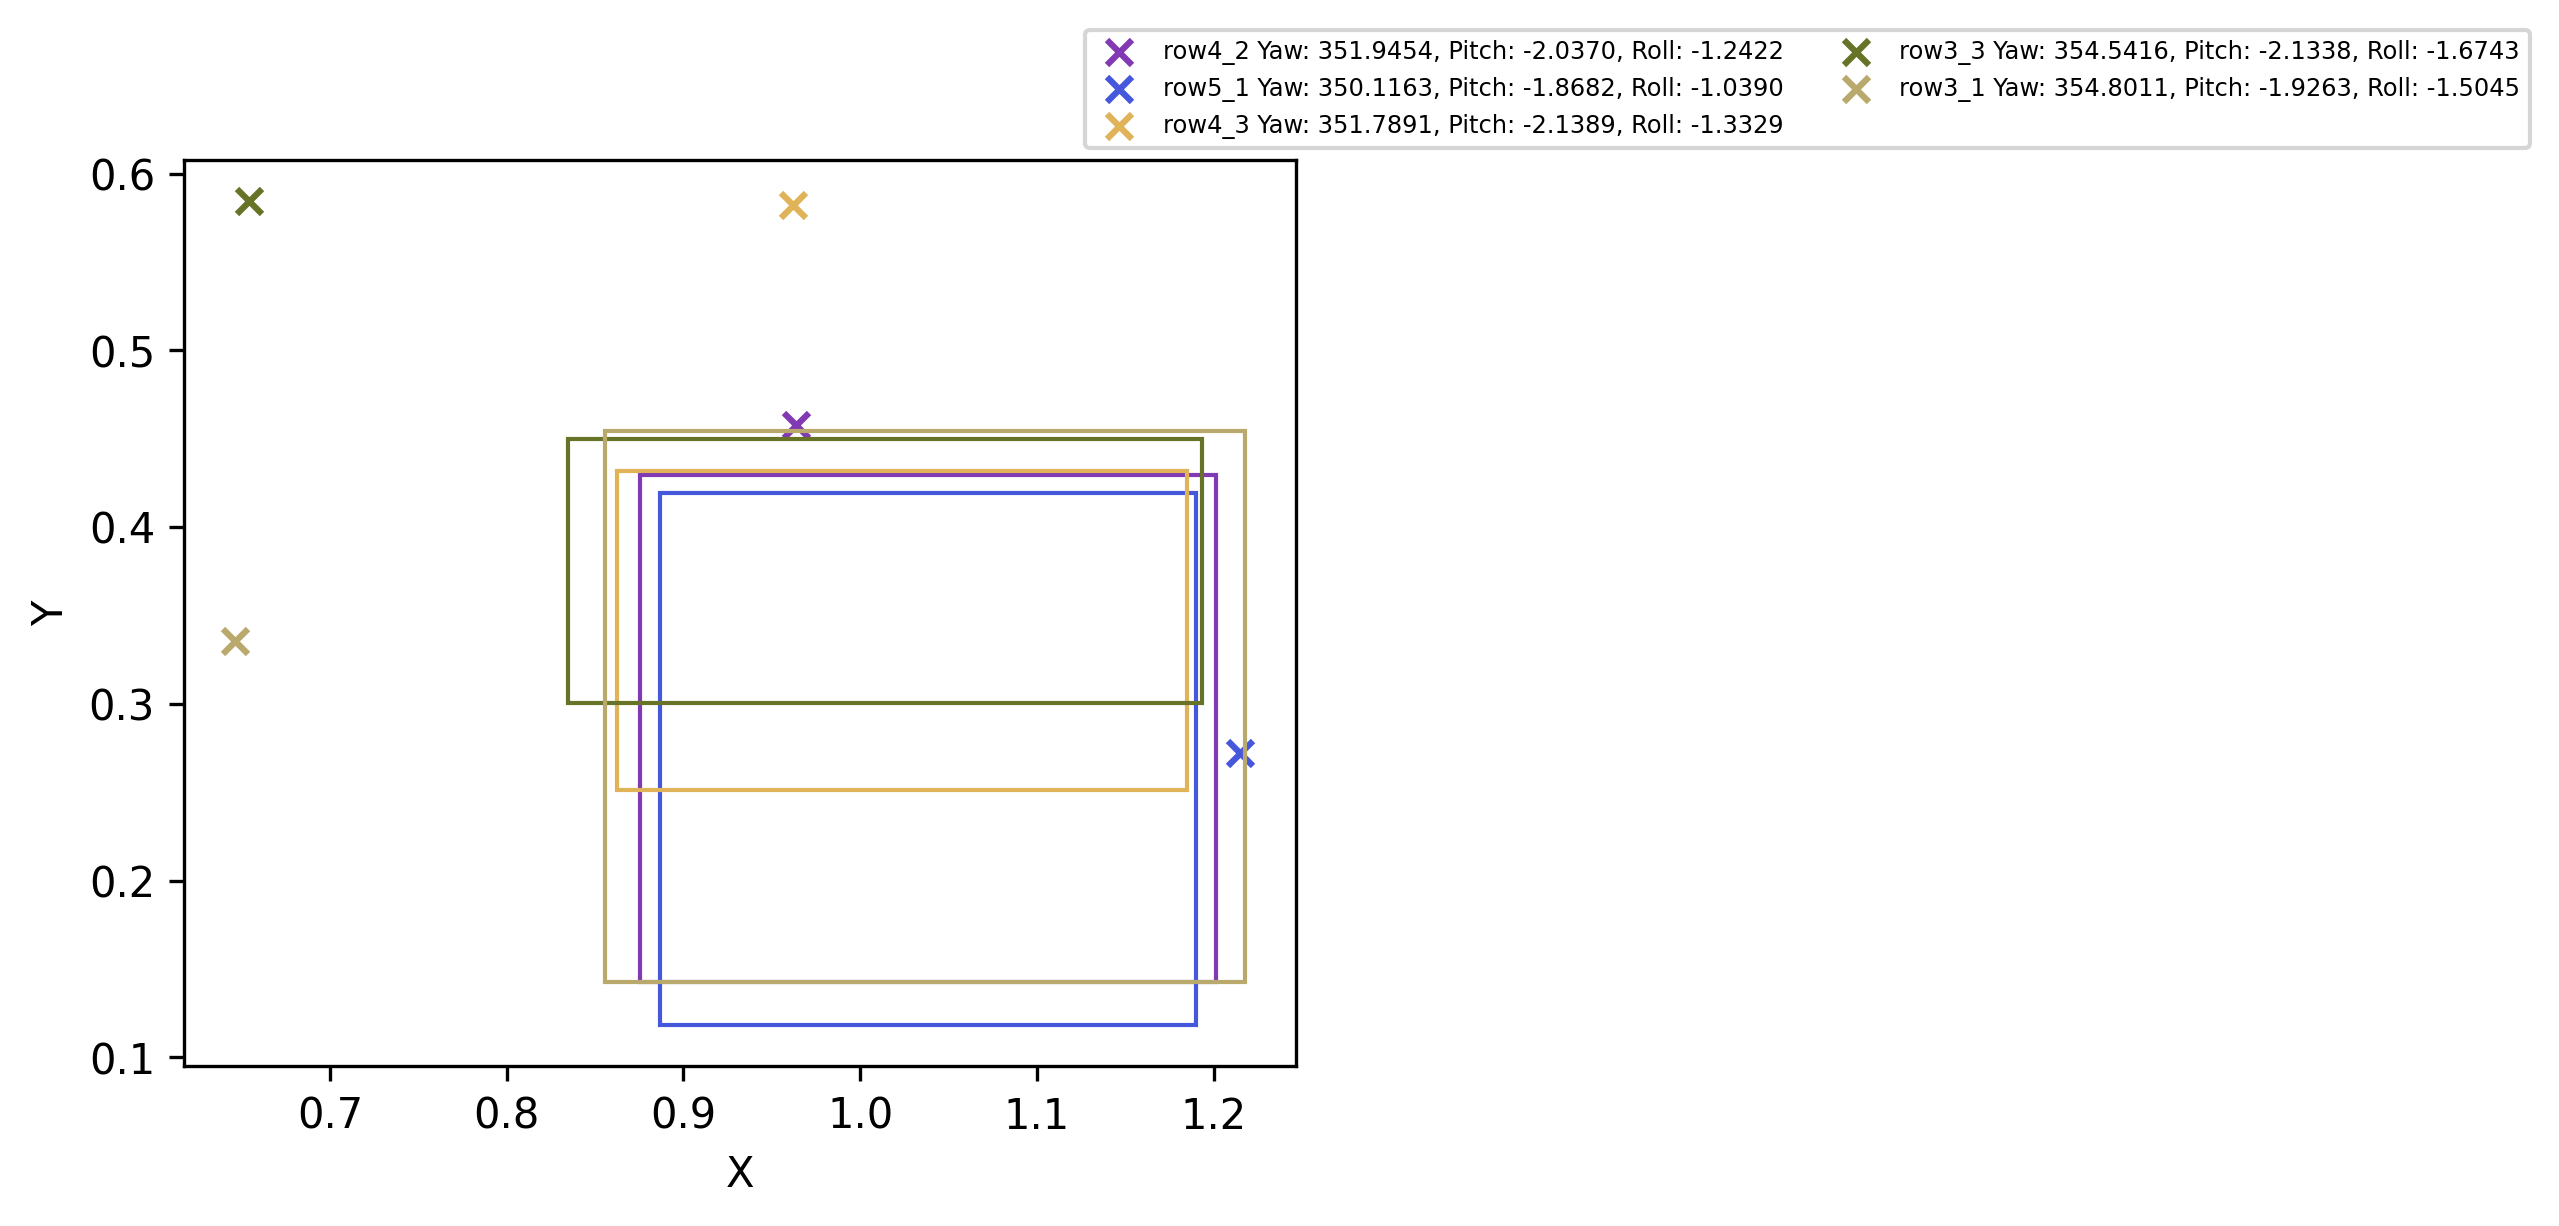

In [36]:
target_to_plot = "target 10"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=None)